In [20]:
import cv2 as cv 
import numpy as np
import scipy
import PIL.Image
import math
import caffe
import time
from config_reader import config_reader
import util
import copy
import matplotlib
%matplotlib inline
import pylab as plt

import os
from scipy.ndimage.filters import gaussian_filter


rootDir = '../sample_image/golfimage/images20'
fileSet = set()

X_data=[]
Y_data=[]

for dir_, _, files in os.walk(rootDir):
    for fileName in files:
        relDir = os.path.relpath(dir_, rootDir)
        relFile = os.path.join(relDir, fileName)
        print(relFile[2:])
        oriImg = cv.imread(rootDir+'/'+relFile[2:]) # B,G,R order
        
        heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
        paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
        
        param, model = config_reader()
        multiplier = [x * model['boxsize'] / oriImg.shape[0] for x in param['scale_search']]

        caffe.set_mode_cpu()
        net = caffe.Net(model['deployFile'], model['caffemodel'], caffe.TEST)

        for m in range(len(multiplier)):
            scale = multiplier[m]
            imageToTest = cv.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)
            imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model['stride'], model['padValue'])
            #print imageToTest_padded.shape

            net.blobs['data'].reshape(*(1, 3, imageToTest_padded.shape[0], imageToTest_padded.shape[1]))
            #net.forward() # dry run
            net.blobs['data'].data[...] = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,2,0,1))/256 - 0.5;
            start_time = time.time()
            output_blobs = net.forward()
            #print('At scale %d, The CNN took %.2f ms.' % (m, 1000 * (time.time() - start_time)))

            # extract outputs, resize, and remove padding
            heatmap = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[1]].data), (1,2,0)) # output 1 is heatmaps
            heatmap = cv.resize(heatmap, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
            heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
            heatmap = cv.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)

            paf = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[0]].data), (1,2,0)) # output 0 is PAFs
            paf = cv.resize(paf, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
            paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
            paf = cv.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)  

            heatmap_avg = heatmap_avg + heatmap / len(multiplier)
            paf_avg = paf_avg + paf / len(multiplier)

        print ('----Safe Finish----')

        #plt.imshow(heatmap_avg[:,:,2])
        from scipy.ndimage.filters import gaussian_filter
        all_peaks = []
        peak_counter = 0

        for part in range(19-1):
            x_list = []
            y_list = []
            map_ori = heatmap_avg[:,:,part]
            map = gaussian_filter(map_ori, sigma=3)

            map_left = np.zeros(map.shape)
            map_left[1:,:] = map[:-1,:]
            map_right = np.zeros(map.shape)
            map_right[:-1,:] = map[1:,:]
            map_up = np.zeros(map.shape)
            map_up[:,1:] = map[:,:-1]
            map_down = np.zeros(map.shape)
            map_down[:,:-1] = map[:,1:]

            peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
            peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]) # note reverse
            peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
            id = range(peak_counter, peak_counter + len(peaks))
            peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

            all_peaks.append(peaks_with_score_and_id)
            peak_counter += len(peaks)
            
        # find connection in the specified sequence, center 29 is in the position 15
        limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
                   [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
                   [1,16], [16,18], [3,17], [6,18]]
        # the middle joints heatmap correpondence
        mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
                  [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
                  [55,56], [37,38], [45,46]]
        
        connection_all = []
        special_k = []
        mid_num = 10

        for k in range(len(mapIdx)):
            score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
            candA = all_peaks[limbSeq[k][0]-1]
            candB = all_peaks[limbSeq[k][1]-1]
            nA = len(candA)
            nB = len(candB)
            indexA, indexB = limbSeq[k]
            if(nA != 0 and nB != 0):
                connection_candidate = []
                for i in range(nA):
                    for j in range(nB):
                        vec = np.subtract(candB[j][:2], candA[i][:2])
                        norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                        if norm == 0.0:
                            norm = 1.0
                        vec = np.divide(vec, norm)

                        startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                       np.linspace(candA[i][1], candB[j][1], num=mid_num))

                        vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                          for I in range(len(startend))])
                        vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                          for I in range(len(startend))])

                        score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                        score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                        criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                        criterion2 = score_with_dist_prior > 0
                        if criterion1 and criterion2:
                            connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

                connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
                connection = np.zeros((0,5))
                for c in range(len(connection_candidate)):
                    i,j,s = connection_candidate[c][0:3]
                    if(i not in connection[:,3] and j not in connection[:,4]):
                        connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                        if(len(connection) >= min(nA, nB)):
                            break

                connection_all.append(connection)
            else:
                special_k.append(k)
                connection_all.append([])

        # last number in each row is the total parts number of that person
        # the second last number in each row is the score of the overall configuration
        subset = -1 * np.ones((0, 20))
        candidate = np.array([item for sublist in all_peaks for item in sublist])

        for k in range(len(mapIdx)):
            if k not in special_k:
                partAs = connection_all[k][:,0]
                partBs = connection_all[k][:,1]
                indexA, indexB = np.array(limbSeq[k]) - 1

                for i in range(len(connection_all[k])): #= 1:size(temp,1)
                    found = 0
                    subset_idx = [-1, -1]
                    for j in range(len(subset)): #1:size(subset,1):
                        if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                            subset_idx[found] = j
                            found += 1

                    if found == 1:
                        j = subset_idx[0]
                        if(subset[j][indexB] != partBs[i]):
                            subset[j][indexB] = partBs[i]
                            subset[j][-1] += 1
                            subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                    elif found == 2: # if found 2 and disjoint, merge them
                        j1, j2 = subset_idx
                        print "found = 2"
                        membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                        if len(np.nonzero(membership == 2)[0]) == 0: #merge
                            subset[j1][:-2] += (subset[j2][:-2] + 1)
                            subset[j1][-2:] += subset[j2][-2:]
                            subset[j1][-2] += connection_all[k][i][2]
                            subset = np.delete(subset, j2, 0)
                        else: # as like found == 1
                            subset[j1][indexB] = partBs[i]
                            subset[j1][-1] += 1
                            subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

                    # if find no partA in the subset, create a new subset
                    elif not found and k < 17:
                        row = -1 * np.ones(20)
                        row[indexA] = partAs[i]
                        row[indexB] = partBs[i]
                        row[-1] = 2
                        row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                        subset = np.vstack([subset, row])
                            
        # delete some rows of subset which has few parts occur
        deleteIdx = [];
        for i in range(len(subset)):
            if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
                deleteIdx.append(i)
        subset = np.delete(subset, deleteIdx, axis=0)

        for i in range(18):
            for j in range(len(all_peaks[i])):
                X_data.append(all_peaks[i][j][0])
                Y_data.append(all_peaks[i][j][1])
                
print(X_data)
print(Y_data)

001.jpg
----Safe Finish----
041.jpg
----Safe Finish----
081.jpg
----Safe Finish----
121.jpg
----Safe Finish----
161.jpg
----Safe Finish----
201.jpg
----Safe Finish----
241.jpg
----Safe Finish----
281.jpg
----Safe Finish----
321.jpg
----Safe Finish----
361.jpg
----Safe Finish----
401.jpg
----Safe Finish----
441.jpg
----Safe Finish----
481.jpg
----Safe Finish----
[238, 205, 205, 204, 215, 203, 173, 187, 179, 186, 198, 190, 189, 239, 227, 240, 206, 205, 200, 210, 207, 173, 187, 178, 187, 201, 190, 239, 227, 237, 206, 196, 188, 199, 217, 213, 207, 172, 186, 178, 193, 203, 189, 237, 225, 239, 211, 197, 175, 183, 227, 217, 202, 169, 183, 179, 192, 205, 193, 239, 343, 226, 241, 213, 196, 159, 163, 134, 169, 230, 209, 181, 167, 182, 178, 190, 206, 193, 240, 241, 227, 239, 212, 195, 159, 166, 165, 229, 214, 177, 168, 180, 177, 190, 204, 190, 241, 235, 229, 238, 212, 195, 163, 165, 230, 213, 178, 168, 179, 177, 190, 203, 191, 239, 233, 227, 240, 205, 195, 186, 207, 217, 218, 224, 174, 186, 176, 

In [7]:
Xf8=[174, 144, 137, 133, 150, 152, 150, 152, 103, 111, 93, 123, 141, 135, 174, 176, 163, 175, 144, 137, 133, 149, 151, 151, 151, 102, 111, 94, 123, 141, 135, 174, 176, 162, 175, 144, 136, 132, 148, 153, 152, 152, 102, 111, 94, 123, 142, 136, 175, 177, 163, 175, 146, 134, 127, 144, 159, 155, 151, 102, 110, 96, 125, 144, 137, 175, 176, 163, 176, 147, 130, 119, 134, 165, 157, 148, 103, 109, 97, 131, 149, 138, 175, 178, 163, 175, 147, 127, 109, 120, 169, 155, 140, 102, 109, 98, 133, 151, 139, 174, 176, 161, 174, 147, 123, 102, 106, 170, 150, 128, 105, 107, 98, 134, 153, 140, 172, 177, 159, 171, 146, 122, 102, 92, 169, 142, 105, 145, 106, 107, 99, 136, 154, 141, 170, 176, 158, 168, 143, 120, 96, 87, 125, 164, 136, 96, 147, 105, 107, 100, 135, 152, 142, 166, 173, 154, 160, 141, 120, 89, 87, 161, 124, 92, 113, 114, 115, 103, 103, 98, 134, 148, 143, 159, 167, 149, 168, 154, 139, 121, 86, 88, 157, 111, 91, 104, 100, 98, 134, 144, 146, 152, 161, 143, 164, 149, 136, 120, 86, 90, 152, 104, 92, 104, 100, 99, 133, 143, 148, 147, 155, 137, 159, 148, 136, 119, 89, 85, 153, 102, 87, 106, 102, 100, 137, 147, 149, 146, 155, 135, 157, 154, 139, 117, 78, 73, 115, 160, 121, 83, 84, 108, 107, 102, 140, 153, 149, 151, 160, 140, 164, 152, 134, 112, 120, 144, 157, 164, 162, 117, 125, 107, 144, 163, 155, 148, 153, 132, 144, 117, 128, 158, 176, 108, 125, 137, 155, 156, 157, 130, 148, 113, 114, 152, 153, 143, 132, 127, 150, 129, 100, 103, 83, 88, 147, 156, 138, 117, 142, 156, 138, 115, 95, 125, 130, 81, 49, 121, 73, 44, 144, 147, 174, 134, 130, 167, 99, 115, 72, 96, 73, 53, 41, 118, 132, 102, 116, 137, 172, 139, 148, 203, 70, 76, 93, 47, 72, 46, 36, 27, 98, 143, 148, 119, 162, 217, 138, 146, 211, 175, 42, 50, 44, 64, 44, 58, 40, 39, 38, 74, 122, 141, 126, 155, 159, 214, 172, 136, 167, 157, 216, 170, 39, 42, 46]

Yf8=[271, 271, 274, 322, 354, 271, 312, 350, 328, 387, 453, 329, 374, 427, 264, 265, 254, 270, 271, 273, 322, 353, 272, 310, 347, 329, 387, 453, 329, 374, 427, 264, 264, 254, 270, 271, 273, 322, 354, 272, 310, 348, 328, 387, 454, 329, 374, 427, 264, 264, 254, 272, 273, 273, 323, 357, 275, 313, 351, 328, 387, 454, 328, 373, 427, 266, 268, 255, 274, 274, 272, 318, 354, 277, 315, 351, 328, 387, 454, 330, 376, 428, 267, 269, 256, 274, 275, 269, 312, 347, 282, 322, 350, 328, 385, 454, 334, 380, 428, 268, 271, 256, 274, 275, 266, 302, 331, 286, 323, 340, 334, 389, 454, 339, 383, 428, 267, 271, 255, 272, 272, 261, 295, 303, 285, 315, 317, 324, 333, 389, 454, 339, 387, 428, 265, 269, 253, 267, 269, 257, 290, 280, 297, 283, 300, 287, 314, 332, 388, 453, 338, 389, 428, 260, 264, 249, 260, 264, 253, 281, 252, 276, 282, 253, 267, 268, 269, 329, 389, 453, 334, 385, 427, 253, 258, 242, 256, 251, 257, 249, 264, 229, 267, 262, 228, 329, 389, 452, 333, 383, 425, 244, 248, 235, 248, 244, 253, 245, 250, 219, 261, 249, 217, 327, 388, 453, 331, 382, 423, 237, 241, 230, 242, 244, 251, 243, 249, 218, 259, 251, 217, 326, 387, 451, 330, 380, 423, 236, 240, 229, 239, 251, 254, 245, 266, 244, 257, 263, 270, 249, 250, 326, 388, 451, 329, 381, 423, 244, 247, 235, 238, 248, 251, 257, 301, 326, 247, 285, 318, 321, 384, 447, 317, 368, 419, 244, 243, 237, 246, 248, 266, 287, 280, 228, 216, 257, 216, 268, 269, 318, 378, 438, 315, 375, 419, 242, 237, 249, 240, 204, 188, 257, 240, 212, 325, 381, 428, 331, 377, 426, 224, 224, 235, 249, 239, 234, 218, 260, 272, 243, 325, 382, 428, 329, 386, 423, 230, 232, 253, 265, 264, 287, 296, 265, 307, 320, 343, 396, 422, 338, 391, 419, 247, 246, 243, 306, 307, 320, 354, 381, 293, 304, 338, 369, 395, 412, 353, 418, 414, 419, 302, 299, 300, 288, 390, 376, 400, 443, 488, 352, 344, 378, 406, 414, 446, 408, 431, 389, 409, 445, 408, 419, 390, 384, 368]

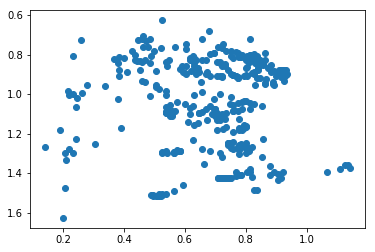

In [8]:
newX = [i*1.0 / (max(Xf8)-min(Xf8)) for i in Xf8]
newY = [j*1.0 / (max(Yf8)-min(Yf8)) for j in Yf8]

plt.plot(newX, newY,"o")
plt.gca().invert_yaxis()

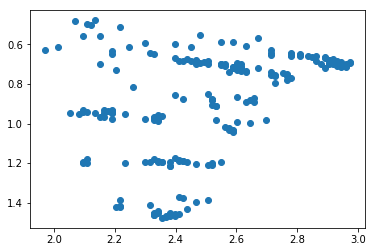

In [17]:
xs11=[215, 189, 192, 185, 189, 186, 184, 188, 160, 176, 175, 158, 159, 169, 170, 216, 208,216, 189, 191, 185, 189, 186, 184, 187, 160, 177, 174, 160, 172, 171, 217, 209,216, 189, 190, 184, 189, 187, 184, 188, 160, 174, 176, 160, 171, 171, 217, 207,214, 191, 183, 175, 185, 199, 194, 190, 158, 172, 174, 171, 176, 170, 214, 214, 205,215, 191, 179, 165, 183, 203, 193, 192, 156, 178, 175, 170, 177, 170, 215, 215, 205,214, 189, 180, 161, 177, 199, 202, 190, 157, 184, 173, 168, 174, 170, 213, 203,213, 191, 180, 160, 181, 202, 201, 195, 158, 186, 172, 170, 174, 170, 211, 213, 203,212, 191, 180, 157, 175, 202, 198, 189, 160, 184, 173, 171, 183, 174, 211, 212, 203,212, 187, 192, 177, 193, 182, 190, 197, 163, 180, 178, 153, 163, 169, 212, 205,211, 188, 199, 194, 176, 171, 175, 176, 150, 154, 162, 213, 210, 198,190, 198, 169, 170, 157, 181, 160, 153, 170, 170, 177, 152, 153, 162, 209, 198,186, 195, 168, 156, 178, 147, 151, 172, 168, 180, 154, 153, 161, 203, 192,183, 191, 164, 179, 162, 175, 144, 154, 155, 171, 171, 183, 153, 154, 162, 198, 186]
ys11=[144, 145, 148, 183, 210, 142, 177, 208, 190, 239, 293, 187, 188, 240, 292, 140, 133,144, 144, 148, 183, 208, 141, 176, 205, 189, 239, 292, 187, 240, 290, 139, 132,143, 144, 147, 182, 209, 141, 177, 206, 190, 240, 293, 188, 240, 292, 138, 132,142, 147, 141, 172, 197, 153, 179, 199, 190, 240, 295, 193, 238, 293, 137, 141, 130,143, 146, 137, 164, 171, 155, 177, 179, 190, 240, 295, 194, 239, 293, 138, 140, 131,143, 145, 140, 147, 137, 152, 157, 139, 194, 241, 296, 196, 244, 294, 138, 132,138, 144, 136, 127, 111, 153, 150, 114, 194, 240, 297, 197, 244, 294, 133, 135, 130,139, 144, 137, 140, 120, 151, 149, 118, 196, 243, 295, 198, 243, 293, 134, 136, 131,141, 143, 149, 176, 200, 138, 174, 197, 191, 242, 288, 187, 241, 284, 136, 132,145, 149, 160, 175, 137, 196, 236, 276, 190, 237, 279, 141, 140, 131,145, 152, 129, 130, 112, 139, 130, 112, 195, 237, 277, 191, 240, 285, 137, 129,140, 145, 119, 96, 135, 123, 97, 193, 240, 281, 189, 241, 286, 129, 122,137, 141, 123, 123, 103, 134, 126, 100, 101, 192, 239, 279, 189, 241, 286, 126, 118]

newX = [i*1.0 / (max(xs11)-min(xs11)) for i in xs11]
newY = [j*1.0 / (max(ys11)-min(ys11)) for j in ys11]

plt.plot(newX, newY,"o")
plt.gca().invert_yaxis()

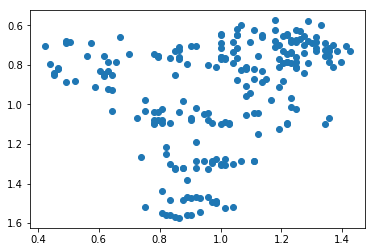

In [11]:
xf01=[97, 76, 73, 77, 91, 80, 81, 90, 55, 60, 61, 64, 67, 65, 94, 86, 95, 74, 73, 79, 89, 77, 80, 89, 47, 54, 55, 57, 60, 59, 92, 96, 83, 99, 79, 72, 67, 82, 87, 85, 87, 53, 61, 59, 66, 69, 64, 98, 101, 87, 99, 76, 63, 91, 47, 58, 61, 91, 87, 46, 55, 61, 62, 60, 71, 71, 65, 98, 100, 90, 93, 73, 58, 90, 38, 70, 34, 57, 88, 36, 83, 32, 57, 70, 64, 61, 59, 74, 73, 66, 90, 94, 91, 77, 86, 73, 58, 33, 31, 87, 51, 83, 36, 57, 62, 62, 75, 73, 67, 83, 88, 73, 91, 74, 58, 89, 33, 36, 63, 89, 34, 37, 59, 64, 63, 75, 76, 68, 89, 93, 77, 73, 98, 79, 65, 43, 47, 93, 79, 62, 57, 67, 65, 73, 81, 70, 96, 99, 86, 93, 100, 79, 78, 82, 98, 81, 90, 99, 58, 70, 66, 66, 74, 72, 99, 102, 91, 104, 82, 73, 94, 48, 96, 67, 91, 49, 46, 70, 74, 68, 59, 72, 72, 103, 96, 77, 66, 90, 46, 84, 63, 88, 44, 42, 81, 81, 76, 63, 67, 71, 92, 78, 89, 76, 63, 89, 45, 45, 62, 90, 45, 88, 41, 69, 78, 74, 79, 71, 72, 86, 91, 81, 77]
yf01=[97, 111, 112, 142, 166, 111, 141, 164, 158, 197, 240, 159, 193, 224, 94, 93, 112, 124, 123, 155, 178, 124, 153, 177, 167, 205, 246, 168, 203, 233, 108, 107, 107, 122, 131, 131, 165, 186, 131, 158, 182, 173, 211, 251, 173, 208, 240, 117, 118, 113, 116, 128, 125, 132, 150, 168, 124, 131, 148, 149, 167, 177, 214, 253, 177, 210, 238, 112, 113, 111, 113, 125, 122, 128, 143, 130, 132, 121, 128, 144, 144, 129, 175, 175, 214, 253, 175, 176, 211, 239, 109, 110, 111, 105, 110, 123, 122, 138, 114, 125, 121, 135, 110, 177, 215, 254, 177, 212, 238, 105, 106, 104, 109, 125, 123, 127, 136, 112, 123, 127, 133, 111, 177, 214, 255, 178, 211, 239, 105, 106, 105, 105, 122, 132, 129, 148, 138, 136, 147, 138, 178, 214, 253, 178, 208, 238, 118, 118, 115, 120, 131, 133, 134, 169, 178, 133, 157, 173, 175, 215, 253, 175, 212, 241, 127, 127, 123, 118, 122, 116, 128, 127, 116, 114, 127, 107, 127, 169, 207, 250, 166, 207, 242, 114, 111, 116, 114, 119, 135, 141, 115, 118, 135, 112, 169, 208, 246, 168, 208, 242, 102, 97, 104, 119, 117, 121, 137, 122, 118, 120, 139, 143, 122, 170, 208, 247, 171, 208, 243, 101, 101, 101, 100]

newX = [i*1.0 / (max(xf01)-min(xf01)) for i in xf01]
newY = [j*1.0 / (max(yf01)-min(yf01)) for j in yf01]

plt.plot(newX, newY,"o")
plt.gca().invert_yaxis()

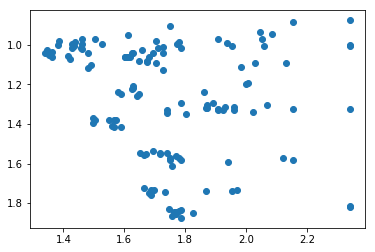

In [13]:
xf02=[252, 253, 299, 307, 272, 271, 290, 284, 271, 339, 306, 300, 333, 308, 316, 253, 264, 239, 287, 295, 282, 259, 280, 279, 273, 259, 327, 293, 288, 324, 297, 302, 240, 253, 248, 293, 296, 281, 268, 291, 285, 270, 324, 297, 292, 330, 303, 306, 249, 260, 236, 277, 256, 282, 322, 299, 343, 346, 301, 289, 291, 330, 303, 304, 236, 247, 234, 282, 258, 299, 338, 308, 351, 355, 301, 286, 294, 334, 309, 306, 232, 233, 247, 246, 290, 285, 275, 260, 295, 309, 275, 323, 301, 292, 339, 288, 305, 245, 256, 309, 335, 369, 361, 281, 330, 278, 277, 354, 350, 336, 323, 309, 308, 312, 304, 309, 303, 279, 405, 405, 356, 347, 358, 405, 367, 338, 405, 373, 373, 341, 405, 405, 373]
yf02=[293, 294, 299, 286, 397, 398, 311, 362, 407, 379, 450, 502, 383, 452, 533, 287, 286, 288, 295, 282, 350, 395, 305, 306, 357, 402, 373, 443, 497, 376, 446, 527, 282, 279, 290, 299, 293, 352, 398, 306, 359, 406, 380, 447, 499, 381, 452, 532, 284, 280, 305, 306, 321, 348, 357, 291, 320, 345, 387, 447, 504, 383, 456, 537, 298, 292, 303, 300, 317, 325, 290, 283, 315, 279, 383, 445, 499, 378, 455, 534, 300, 295, 286, 309, 313, 312, 359, 397, 314, 373, 408, 380, 446, 506, 383, 449, 532, 304, 299, 292, 285, 314, 272, 300, 279, 305, 306, 269, 385, 458, 501, 529, 530, 388, 464, 540, 261, 273, 288, 289, 290, 343, 376, 381, 452, 501, 524, 382, 455, 499, 523, 252, 254]

newX = [i*1.0 / (max(xf02)-min(xf02)) for i in xf02]
newY = [j*1.0 / (max(yf02)-min(yf02)) for j in yf02]

plt.plot(newX, newY,"o")
plt.gca().invert_yaxis()

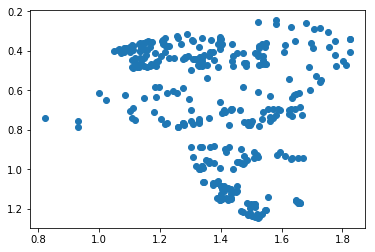

In [16]:
xf03=[283, 320, 358, 351, 246, 304, 338, 349, 335, 311, 295, 300, 316, 333, 290, 252, 287, 327, 378, 373, 248, 311, 351, 347, 337, 312, 330, 295, 302, 318, 336, 297, 258, 296, 338, 394, 389, 255, 319, 362, 347, 338, 318, 335, 336, 295, 306, 323, 344, 310, 269, 297, 342, 395, 390, 252, 365, 341, 335, 313, 333, 289, 302, 322, 343, 310, 269, 295, 342, 383, 375, 248, 334, 330, 311, 332, 283, 297, 318, 341, 310, 268, 294, 342, 364, 338, 246, 264, 332, 328, 311, 332, 280, 295, 318, 339, 310, 269, 295, 343, 363, 353, 247, 255, 267, 331, 327, 312, 331, 280, 296, 318, 338, 311, 270, 297, 344, 366, 361, 250, 227, 207, 333, 326, 310, 326, 327, 284, 298, 316, 336, 312, 272, 298, 341, 368, 363, 255, 222, 183, 331, 324, 308, 284, 297, 315, 334, 309, 271, 301, 339, 376, 370, 264, 241, 207, 328, 323, 310, 283, 293, 316, 331, 311, 273, 267, 309, 289, 288, 272, 329, 347, 339, 291, 310, 310, 317, 320, 337, 263, 270, 295, 238, 285, 277, 266, 247, 293, 272, 246, 319, 317, 309, 345, 354, 366, 233, 237, 256, 240, 285, 273, 263, 245, 296, 279, 248, 318, 314, 308, 349, 352, 366, 236, 240, 260, 245, 291, 259, 276, 289, 323, 327, 312, 314, 306, 308, 354, 358, 367, 239, 245, 269, 247, 299, 260, 301, 361, 339, 380, 384, 313, 303, 305, 362, 363, 367, 242, 247, 270, 253, 305, 264, 329, 328, 405, 357, 344, 400, 405, 313, 297, 299, 368, 365, 367, 368, 246, 254, 279, 259, 303, 265, 338, 379, 341, 405, 383, 318, 296, 298, 369, 371, 369, 251, 261, 286, 252, 302, 261, 320, 377, 343, 402, 394, 313, 289, 305, 361, 362, 369, 245, 254, 280, 256, 306, 292, 283, 262, 319, 310, 270, 325, 315, 311, 342, 328, 367, 252, 257, 282, 297, 336, 339, 310, 257, 251, 253, 351, 326, 313, 302, 291, 323, 345, 245, 291, 255]
yf03=[204, 199, 172, 123, 208, 161, 118, 343, 423, 505, 350, 442, 508, 547, 160, 167, 198, 192, 179, 121, 203, 158, 114, 341, 431, 510, 545, 347, 446, 512, 554, 155, 163, 200, 197, 196, 142, 202, 169, 131, 350, 435, 515, 546, 547, 355, 450, 516, 560, 161, 166, 202, 198, 222, 177, 203, 162, 347, 439, 515, 550, 352, 450, 517, 561, 154, 160, 211, 208, 260, 223, 213, 350, 443, 523, 556, 356, 457, 522, 569, 159, 164, 219, 215, 289, 283, 223, 295, 360, 449, 530, 567, 365, 463, 531, 576, 166, 170, 222, 218, 297, 322, 226, 298, 347, 361, 451, 535, 569, 365, 464, 534, 579, 169, 173, 221, 217, 287, 334, 225, 302, 364, 356, 450, 534, 562, 564, 361, 461, 535, 577, 170, 175, 219, 217, 285, 340, 222, 286, 345, 354, 447, 533, 357, 458, 532, 575, 170, 175, 220, 219, 279, 338, 221, 289, 351, 353, 447, 537, 356, 456, 537, 571, 172, 175, 199, 225, 230, 300, 356, 221, 293, 363, 358, 461, 536, 360, 463, 570, 192, 189, 178, 192, 203, 202, 271, 320, 204, 284, 345, 323, 412, 493, 322, 425, 536, 186, 181, 166, 189, 201, 203, 272, 327, 200, 284, 349, 325, 416, 496, 323, 431, 539, 184, 180, 166, 189, 206, 222, 280, 326, 192, 271, 332, 331, 411, 495, 326, 433, 541, 183, 177, 161, 185, 195, 217, 249, 252, 175, 245, 254, 328, 412, 496, 322, 438, 541, 179, 174, 156, 179, 189, 212, 214, 215, 159, 188, 167, 211, 158, 326, 413, 494, 542, 322, 439, 543, 173, 167, 150, 177, 189, 209, 193, 134, 171, 188, 133, 323, 412, 494, 319, 439, 543, 170, 166, 147, 187, 197, 219, 222, 167, 176, 220, 162, 329, 413, 502, 326, 440, 545, 180, 176, 156, 195, 208, 204, 274, 330, 211, 306, 358, 325, 424, 503, 330, 433, 544, 187, 184, 171, 209, 190, 180, 181, 225, 224, 214, 338, 418, 504, 343, 435, 503, 529, 178, 164, 181]

newX = [i*1.0 / (max(xf03)-min(xf03)) for i in xf03]
newY = [j*1.0 / (max(yf03)-min(yf03)) for j in yf03]

plt.plot(newX, newY,"o")
plt.gca().invert_yaxis()

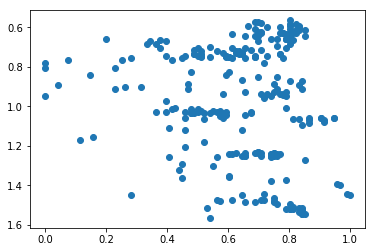

In [20]:
xf04=[67, 48, 58, 68, 78, 38, 30, 48, 66, 76, 35, 54, 63, 66, 59, 73, 52, 59, 69, 81, 44, 47, 67, 77, 38, 58, 66, 71, 73, 63, 77, 57, 63, 71, 83, 49, 49, 67, 77, 40, 59, 68, 76, 78, 67, 76, 56, 61, 70, 83, 49, 63, 80, 48, 67, 78, 41, 60, 69, 75, 66, 79, 59, 65, 73, 87, 52, 55, 72, 81, 46, 63, 72, 77, 80, 68, 77, 57, 66, 75, 88, 47, 57, 73, 81, 46, 63, 72, 75, 68, 76, 57, 66, 76, 88, 47, 56, 72, 81, 44, 62, 72, 74, 67, 77, 58, 66, 75, 87, 49, 56, 71, 80, 46, 63, 73, 76, 78, 68, 82, 62, 62, 74, 91, 60, 72, 91, 54, 72, 80, 53, 68, 78, 80, 82, 70, 80, 61, 54, 56, 76, 68, 72, 81, 55, 56, 74, 81, 63, 72, 77, 77, 66, 79, 63, 48, 45, 62, 76, 81, 77, 52, 73, 81, 65, 71, 69, 77, 79, 67, 77, 60, 47, 45, 58, 74, 80, 73, 50, 71, 81, 65, 68, 62, 74, 77, 64, 75, 57, 67, 76, 83, 46, 38, 62, 82, 82, 44, 53, 59, 74, 70, 35, 43, 49, 22, 27, 40, 69, 25, 62, 24, 57, 71, 42, 95, 52, 44, 71, 43, 96, 51, 33, 36, 32, 38, 0, 14, 4, 22, 36, 19, 39, 43, 71, 50, 39, 76, 0, 7, 0, 11, 50, 58, 92, 55, 15, 44, 58, 27, 93, 54]
yf04=[94, 104, 105, 131, 149, 104, 126, 144, 173, 213, 144, 176, 208, 90, 89, 97, 105, 106, 134, 153, 104, 145, 172, 213, 144, 174, 208, 92, 92, 90, 96, 105, 106, 133, 152, 103, 143, 172, 213, 142, 174, 206, 92, 93, 90, 92, 102, 103, 131, 150, 101, 130, 149, 142, 173, 213, 141, 173, 206, 88, 85, 88, 99, 100, 128, 148, 98, 143, 173, 212, 142, 173, 205, 83, 84, 81, 91, 104, 104, 132, 150, 103, 146, 175, 214, 145, 175, 207, 88, 87, 92, 104, 105, 133, 151, 103, 145, 174, 214, 144, 175, 208, 88, 87, 92, 105, 105, 131, 148, 105, 146, 174, 212, 145, 175, 209, 89, 88, 88, 90, 102, 103, 131, 148, 102, 130, 148, 144, 173, 215, 143, 173, 211, 86, 86, 84, 83, 101, 101, 131, 130, 100, 124, 128, 147, 148, 174, 214, 146, 175, 209, 79, 80, 86, 99, 99, 128, 121, 99, 122, 122, 145, 174, 216, 144, 175, 202, 82, 82, 80, 88, 101, 100, 124, 116, 103, 125, 119, 145, 176, 216, 145, 175, 203, 84, 85, 83, 106, 118, 119, 141, 148, 116, 136, 157, 178, 216, 157, 182, 206, 103, 104, 96, 106, 104, 128, 106, 107, 109, 126, 102, 107, 144, 175, 185, 202, 219, 148, 174, 181, 203, 212, 94, 93, 96, 94, 113, 118, 125, 113, 99, 92, 155, 191, 193, 149, 176, 192, 109, 107, 133, 164, 165, 190, 195, 207, 162, 169, 189, 203, 196, 206]

newX = [i*1.0 / (max(xf04)-min(xf04)) for i in xf04]
newY = [j*1.0 / (max(yf04)-min(yf04)) for j in yf04]

plt.plot(newX, newY,"o")
plt.gca().invert_yaxis()

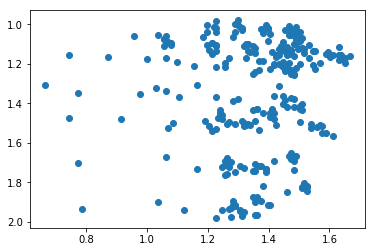

In [22]:
xf05=[230, 204, 205, 209, 222, 203, 209, 217, 182, 186, 186, 186, 193, 194, 230, 231, 219, 226, 200, 198, 204, 217, 202, 204, 212, 179, 184, 184, 185, 191, 192, 225, 214, 216, 193, 177, 173, 192, 208, 208, 206, 173, 178, 180, 193, 196, 191, 214, 213, 203, 218, 195, 179, 163, 171, 212, 210, 187, 178, 182, 185, 201, 209, 206, 216, 213, 204, 212, 191, 173, 152, 173, 209, 206, 185, 176, 179, 184, 200, 209, 215, 210, 213, 198, 208, 186, 169, 149, 201, 169, 205, 202, 182, 175, 177, 182, 198, 207, 213, 205, 208, 194, 209, 188, 171, 150, 173, 206, 203, 183, 175, 178, 181, 199, 208, 214, 207, 210, 196, 211, 191, 173, 152, 173, 208, 205, 184, 185, 176, 179, 182, 200, 210, 215, 208, 211, 197, 211, 190, 173, 151, 172, 208, 205, 183, 175, 178, 181, 199, 209, 215, 209, 212, 197, 210, 188, 170, 149, 169, 207, 202, 182, 174, 177, 179, 198, 208, 213, 207, 210, 195, 211, 187, 171, 150, 167, 204, 200, 181, 168, 176, 176, 191, 200, 195, 209, 210, 197, 219, 190, 202, 195, 205, 177, 164, 183, 200, 170, 194, 180, 153, 180, 190, 218, 221, 207, 201, 173, 191, 181, 193, 190, 155, 145, 156, 192, 171, 177, 173, 151, 164, 158, 199, 189, 149, 123, 141, 150, 138, 105, 94, 109, 129, 150, 146, 105, 109, 111, 146, 135, 231, 208, 209, 213, 227, 206, 213, 221, 222, 187, 191, 192, 188, 196, 198, 230, 230, 227, 233, 207, 209, 212, 224, 205, 212, 220, 186, 190, 191, 189, 196, 197, 233, 235, 224]
yf05=[237, 245, 249, 285, 312, 243, 277, 303, 302, 347, 392, 301, 345, 381, 232, 232, 228, 234, 243, 247, 282, 307, 241, 274, 300, 300, 345, 390, 299, 343, 377, 229, 226, 235, 248, 245, 275, 287, 252, 276, 285, 308, 353, 397, 309, 351, 382, 230, 225, 227, 228, 238, 235, 244, 220, 242, 246, 221, 303, 351, 396, 304, 349, 372, 222, 225, 219, 218, 230, 228, 222, 209, 233, 232, 207, 297, 346, 391, 297, 340, 371, 213, 215, 211, 212, 223, 222, 216, 232, 202, 226, 226, 201, 291, 340, 385, 291, 335, 367, 207, 207, 206, 208, 221, 220, 213, 198, 224, 223, 197, 288, 337, 381, 287, 332, 363, 203, 204, 202, 213, 225, 223, 220, 205, 228, 228, 204, 205, 293, 341, 386, 291, 335, 367, 208, 209, 205, 212, 223, 222, 219, 204, 227, 228, 202, 292, 340, 385, 291, 335, 366, 207, 209, 206, 216, 228, 227, 223, 209, 231, 232, 209, 296, 344, 389, 295, 338, 368, 212, 212, 210, 226, 235, 231, 235, 214, 239, 242, 214, 299, 346, 390, 299, 340, 366, 221, 221, 218, 247, 252, 264, 291, 278, 240, 263, 277, 274, 305, 345, 388, 301, 341, 377, 243, 240, 240, 234, 245, 250, 279, 238, 288, 239, 266, 275, 287, 310, 354, 398, 307, 348, 390, 229, 229, 216, 234, 236, 269, 272, 232, 263, 271, 297, 336, 382, 296, 342, 389, 212, 213, 236, 248, 253, 288, 315, 245, 282, 304, 305, 304, 350, 395, 303, 348, 385, 232, 224, 232, 240, 248, 252, 287, 312, 245, 284, 306, 305, 350, 395, 304, 348, 385, 235, 233, 231]

newX = [i*1.0 / (max(xf05)-min(xf05)) for i in xf05]
newY = [j*1.0 / (max(yf05)-min(yf05)) for j in yf05]

plt.plot(newX, newY,"o")
plt.gca().invert_yaxis()

In [ ]:
xf06=[244, 224, 208, 176, 193, 239, 218, 198, 197, 191, 187, 222, 216, 208, 243, 234, 234, 210, 194, 163, 180, 225, 203, 187, 185, 188, 194, 209, 204, 203, 200, 233, 235, 223, 212, 191, 177, 148, 164, 205, 183, 168, 169, 171, 172, 194, 201, 203, 211, 213, 202, 183, 164, 152, 126, 134, 175, 153, 141, 141, 137, 134, 166, 184, 199, 182, 185, 173, 173, 154, 144, 165, 114, 124, 166, 133, 141, 131, 132, 173, 124, 193, 121, 132, 156, 177, 127, 193, 120, 173, 176, 164, 170, 151, 141, 153, 125, 127, 160, 138, 128, 128, 118, 188, 107, 149, 169, 118, 187, 108, 168, 170, 159, 165, 149, 141, 131, 125, 158, 137, 128, 125, 144, 161, 111, 167, 95, 128, 146, 161, 112, 167, 95, 165, 168, 158, 163, 150, 136, 113, 119, 163, 146, 128, 122, 112, 81, 144, 152, 151, 162, 166, 154, 169, 152, 138, 135, 148, 167, 169, 164, 125, 120, 81, 146, 154, 147, 167, 171, 158, 168, 153, 260, 143, 166, 145, 169, 164, 170, 171, 127, 119, 82, 143, 148, 142, 166, 170, 158, 170, 150, 254, 253, 145, 158, 173, 173, 142, 128, 173, 122, 126, 86, 131, 113, 128, 87, 86, 131, 170, 167, 157, 245, 134, 230, 147, 97, 90, 121, 92, 82, 111, 105, 75, 94, 107, 107, 157, 153, 138, 81, 97, 99, 67, 40, 9, 65, 69, 57, 42, 45, 48, 97, 82, 159, 47, 144, 64, 51, 174, 31, 8, 0, 33, 34, 34, 7, 9, 7, 150, 64, 47]
yf06=[119, 123, 115, 117, 105, 131, 136, 111, 182, 222, 248, 185, 225, 265, 114, 111, 119, 121, 113, 111, 101, 130, 131, 108, 181, 224, 261, 183, 223, 224, 261, 114, 116, 110, 122, 123, 115, 110, 100, 132, 134, 108, 180, 218, 254, 180, 214, 254, 117, 119, 113, 132, 134, 128, 128, 108, 140, 140, 111, 187, 224, 257, 187, 216, 244, 127, 129, 122, 137, 134, 125, 145, 129, 110, 143, 117, 139, 113, 189, 213, 226, 244, 258, 188, 190, 215, 224, 243, 257, 132, 135, 126, 136, 138, 130, 118, 123, 106, 146, 139, 110, 187, 221, 242, 254, 187, 214, 221, 240, 253, 132, 133, 128, 143, 143, 135, 126, 110, 150, 139, 113, 186, 188, 212, 218, 243, 251, 187, 187, 211, 217, 243, 250, 138, 140, 133, 150, 150, 143, 154, 146, 158, 163, 149, 190, 219, 248, 194, 217, 246, 146, 148, 141, 149, 152, 152, 182, 192, 153, 172, 190, 184, 217, 242, 187, 214, 244, 145, 146, 144, 147, 149, 73, 151, 170, 177, 190, 151, 171, 190, 186, 218, 236, 188, 213, 244, 144, 145, 140, 145, 142, 72, 73, 134, 155, 174, 163, 128, 120, 170, 179, 214, 235, 242, 173, 213, 234, 235, 242, 142, 142, 136, 73, 138, 73, 149, 119, 115, 127, 118, 104, 188, 218, 235, 181, 218, 244, 133, 133, 123, 143, 150, 149, 135, 145, 142, 193, 224, 261, 186, 221, 253, 130, 123, 91, 152, 93, 159, 181, 90, 146, 163, 162, 205, 237, 277, 199, 235, 264, 70, 138, 131]

In [ ]:
xf07=[147, 130, 121, 138, 157, 139, 150, 160, 119, 107, 92, 139, 150, 152, 143, 147, 130, 120, 256, 109, 93, 99, 109, 124, 124, 119, 100, 94, 88, 124, 137, 146, 116, 123, 263, 103, 102, 92, 77, 65, 64, 53, 106, 87, 63, 88, 85, 82, 110, 122, 133, 98, 105, 87, 99, 87, 74, 55, 34, 100, 72, 41, 80, 78, 76, 102, 115, 124, 95, 102, 84, 96, 84, 71, 49, 44, 97, 64, 47, 77, 76, 122, 76, 98, 110, 122, 92, 100, 83, 90, 90, 84, 61, 59, 95, 64, 58, 81, 110, 77, 122, 75, 95, 110, 76, 121, 75, 87, 95, 82, 101, 80, 87, 91, 65, 86, 58, 61, 94, 106, 74, 118, 71, 83, 104, 73, 117, 71, 78, 84, 93, 74, 285, 85, 90, 56, 95, 67, 82, 56, 66, 93, 104, 72, 117, 70, 79, 104, 71, 116, 69, 74, 280, 220, 79, 89, 68, 82, 87, 80, 53, 63, 92, 79, 104, 69, 117, 70, 83, 104, 69, 117, 69, 68, 72, 83, 62, 78, 82, 77, 49, 55, 95, 106, 66, 118, 70, 80, 105, 66, 118, 70, 61, 66, 77, 72, 217, 80, 76, 56, 52, 85, 55, 48, 80, 119, 69, 137, 75, 99, 119, 70, 137, 75, 70, 216, 77, 228, 65, 87, 98, 224, 97, 86, 64, 60, 108, 75, 61, 98, 84, 85, 120, 139, 158, 95, 223, 103, 237, 89, 109, 131, 122, 109, 96, 92, 136, 124, 104, 118, 105, 91, 142, 158, 163, 127, 134, 117, 148, 233, 137, 123, 142, 165, 151, 165, 174, 124, 123, 109, 144, 161, 167, 144, 233, 149, 246, 132, 144, 92, 132, 120, 121, 141, 145, 150, 154, 119, 118, 112, 138, 151, 168, 140, 144, 95, 129, 150, 248, 133, 126, 141, 120, 144, 128, 141, 143, 113, 121, 107, 128, 139, 146, 148, 243, 140, 167, 229, 143, 150, 145, 152, 135, 111, 90, 117, 123, 140, 96, 109, 138, 139, 168, 164, 150, 150, 164, 172, 170, 136, 120, 103, 145, 151, 136, 126, 134, 136, 161, 144, 133, 153, 159, 176, 185, 148, 150, 143, 170, 175, 187, 153, 143, 137, 136, 148, 139, 151, 142, 148, 151, 160, 170, 167, 161, 159, 161, 173, 174, 192, 137, 144, 154, 146, 151, 134, 117, 103, 168, 182, 180, 151, 161, 185, 170, 168, 168, 143, 151, 139, 159, 147, 149, 133, 121, 119, 165, 174, 175, 142, 142, 142, 163, 165, 167, 143, 151, 138, 158, 139, 140, 124, 122, 136, 155, 162, 156, 130, 128, 126, 151, 156, 165, 135, 143, 130, 150]
yf07=[70, 88, 91, 118, 138, 85, 111, 134, 146, 179, 213, 143, 173, 207, 66, 66, 64, 74, 237, 92, 92, 120, 142, 91, 116, 136, 148, 183, 215, 145, 177, 209, 69, 70, 227, 67, 74, 91, 90, 110, 111, 122, 91, 112, 121, 148, 184, 218, 147, 177, 207, 69, 70, 68, 72, 86, 85, 107, 98, 87, 91, 89, 147, 183, 217, 145, 178, 208, 67, 68, 64, 69, 84, 85, 97, 76, 84, 81, 71, 142, 180, 207, 215, 141, 176, 206, 64, 66, 62, 69, 84, 83, 90, 85, 84, 82, 68, 140, 176, 179, 207, 214, 139, 174, 181, 206, 216, 64, 66, 64, 69, 70, 85, 85, 72, 85, 83, 69, 142, 176, 179, 209, 216, 142, 176, 179, 208, 217, 66, 68, 70, 70, 180, 84, 85, 85, 112, 68, 84, 80, 66, 141, 176, 177, 207, 213, 142, 174, 180, 206, 215, 66, 175, 252, 67, 68, 70, 84, 84, 84, 80, 65, 140, 141, 176, 178, 205, 213, 141, 175, 180, 204, 214, 65, 66, 68, 73, 84, 84, 84, 85, 71, 142, 174, 179, 205, 212, 144, 173, 180, 205, 214, 69, 69, 68, 74, 250, 82, 81, 82, 72, 84, 87, 70, 144, 169, 177, 193, 212, 141, 169, 177, 193, 212, 70, 240, 71, 247, 66, 67, 76, 250, 85, 84, 96, 77, 85, 92, 73, 144, 174, 208, 141, 167, 187, 72, 240, 72, 248, 67, 71, 82, 89, 90, 108, 89, 89, 100, 88, 142, 172, 208, 138, 161, 188, 78, 78, 74, 97, 247, 102, 106, 131, 138, 99, 114, 130, 137, 162, 194, 134, 154, 186, 95, 236, 94, 245, 92, 111, 204, 108, 115, 132, 130, 100, 113, 127, 142, 169, 196, 137, 162, 190, 109, 106, 201, 108, 110, 260, 108, 115, 128, 133, 120, 143, 100, 134, 137, 168, 197, 135, 158, 186, 109, 252, 108, 86, 250, 91, 103, 131, 144, 79, 86, 90, 132, 167, 181, 192, 127, 152, 184, 83, 84, 73, 81, 87, 103, 120, 75, 85, 92, 131, 157, 176, 127, 157, 178, 65, 61, 55, 71, 71, 94, 117, 69, 89, 100, 123, 160, 193, 124, 157, 187, 52, 55, 50, 71, 73, 98, 121, 68, 91, 101, 123, 157, 193, 121, 156, 190, 47, 47, 51, 48, 71, 73, 90, 104, 69, 95, 118, 127, 160, 181, 124, 160, 195, 45, 45, 50, 49, 50, 73, 75, 100, 121, 72, 94, 108, 129, 161, 183, 127, 163, 196, 47, 47, 52, 51, 52, 75, 76, 104, 122, 73, 96, 109, 129, 163, 192, 128, 162, 195, 49, 49, 53, 52]

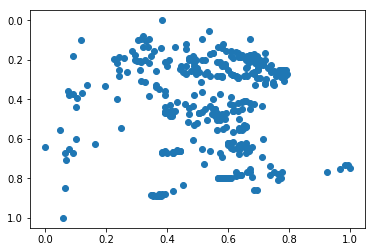

In [3]:
xf08=[174, 144, 137, 133, 150, 152, 150, 152, 103, 111, 93, 123, 141, 135, 174, 176, 163, 175, 144, 137, 133, 149, 151, 151, 151, 102, 111, 94, 123, 141, 135, 174, 176, 162, 175, 144, 136, 132, 148, 153, 152, 152, 102, 111, 94, 123, 142, 136, 175, 177, 163, 175, 146, 134, 127, 144, 159, 155, 151, 102, 110, 96, 125, 144, 137, 175, 176, 163, 176, 147, 130, 119, 134, 165, 157, 148, 103, 109, 97, 131, 149, 138, 175, 178, 163, 175, 147, 127, 109, 120, 169, 155, 140, 102, 109, 98, 133, 151, 139, 174, 176, 161, 174, 147, 123, 102, 106, 170, 150, 128, 105, 107, 98, 134, 153, 140, 172, 177, 159, 171, 146, 122, 102, 92, 169, 142, 105, 145, 106, 107, 99, 136, 154, 141, 170, 176, 158, 168, 143, 120, 96, 87, 125, 164, 136, 96, 147, 105, 107, 100, 135, 152, 142, 166, 173, 154, 160, 141, 120, 89, 87, 161, 124, 92, 113, 114, 115, 103, 103, 98, 134, 148, 143, 159, 167, 149, 168, 154, 139, 121, 86, 88, 157, 111, 91, 104, 100, 98, 134, 144, 146, 152, 161, 143, 164, 149, 136, 120, 86, 90, 152, 104, 92, 104, 100, 99, 133, 143, 148, 147, 155, 137, 159, 148, 136, 119, 89, 85, 153, 102, 87, 106, 102, 100, 137, 147, 149, 146, 155, 135, 157, 154, 139, 117, 78, 73, 115, 160, 121, 83, 84, 108, 107, 102, 140, 153, 149, 151, 160, 140, 164, 152, 134, 112, 120, 144, 157, 164, 162, 117, 125, 107, 144, 163, 155, 148, 153, 132, 144, 117, 128, 158, 176, 108, 125, 137, 155, 156, 157, 130, 148, 113, 114, 152, 153, 143, 132, 127, 150, 129, 100, 103, 83, 88, 147, 156, 138, 117, 142, 156, 138, 115, 95, 125, 130, 81, 49, 121, 73, 44, 144, 147, 174, 134, 130, 167, 99, 115, 72, 96, 73, 53, 41, 118, 132, 102, 116, 137, 172, 139, 148, 203, 70, 76, 93, 47, 72, 46, 36, 27, 98, 143, 148, 119, 162, 217, 138, 146, 211, 175, 42, 50, 44, 64, 44, 58, 40, 39, 38, 74, 122, 141, 126, 155, 159, 214, 172, 136, 167, 157, 216, 170, 39, 42, 46]
yf08=[271, 271, 274, 322, 354, 271, 312, 350, 328, 387, 453, 329, 374, 427, 264, 265, 254, 270, 271, 273, 322, 353, 272, 310, 347, 329, 387, 453, 329, 374, 427, 264, 264, 254, 270, 271, 273, 322, 354, 272, 310, 348, 328, 387, 454, 329, 374, 427, 264, 264, 254, 272, 273, 273, 323, 357, 275, 313, 351, 328, 387, 454, 328, 373, 427, 266, 268, 255, 274, 274, 272, 318, 354, 277, 315, 351, 328, 387, 454, 330, 376, 428, 267, 269, 256, 274, 275, 269, 312, 347, 282, 322, 350, 328, 385, 454, 334, 380, 428, 268, 271, 256, 274, 275, 266, 302, 331, 286, 323, 340, 334, 389, 454, 339, 383, 428, 267, 271, 255, 272, 272, 261, 295, 303, 285, 315, 317, 324, 333, 389, 454, 339, 387, 428, 265, 269, 253, 267, 269, 257, 290, 280, 297, 283, 300, 287, 314, 332, 388, 453, 338, 389, 428, 260, 264, 249, 260, 264, 253, 281, 252, 276, 282, 253, 267, 268, 269, 329, 389, 453, 334, 385, 427, 253, 258, 242, 256, 251, 257, 249, 264, 229, 267, 262, 228, 329, 389, 452, 333, 383, 425, 244, 248, 235, 248, 244, 253, 245, 250, 219, 261, 249, 217, 327, 388, 453, 331, 382, 423, 237, 241, 230, 242, 244, 251, 243, 249, 218, 259, 251, 217, 326, 387, 451, 330, 380, 423, 236, 240, 229, 239, 251, 254, 245, 266, 244, 257, 263, 270, 249, 250, 326, 388, 451, 329, 381, 423, 244, 247, 235, 238, 248, 251, 257, 301, 326, 247, 285, 318, 321, 384, 447, 317, 368, 419, 244, 243, 237, 246, 248, 266, 287, 280, 228, 216, 257, 216, 268, 269, 318, 378, 438, 315, 375, 419, 242, 237, 249, 240, 204, 188, 257, 240, 212, 325, 381, 428, 331, 377, 426, 224, 224, 235, 249, 239, 234, 218, 260, 272, 243, 325, 382, 428, 329, 386, 423, 230, 232, 253, 265, 264, 287, 296, 265, 307, 320, 343, 396, 422, 338, 391, 419, 247, 246, 243, 306, 307, 320, 354, 381, 293, 304, 338, 369, 395, 412, 353, 418, 414, 419, 302, 299, 300, 288, 390, 376, 400, 443, 488, 352, 344, 378, 406, 414, 446, 408, 431, 389, 409, 445, 408, 419, 390, 384, 368]

newX = [float(i-min(xf08)) / (max(xf08)-min(xf08)) for i in xf08]
newY = [float(j-min(yf08)) / (max(yf08)-min(yf08)) for j in yf08]

plt.plot(newX, newY,"o")
plt.gca().invert_yaxis()

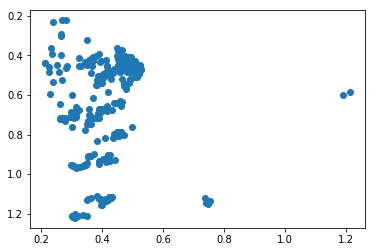

In [32]:
xs01=[166, 135, 125, 130, 143, 145, 144, 145, 98, 106, 97, 120, 131, 134, 166, 152, 153, 171, 142, 130, 134, 147, 152, 149, 149, 102, 112, 103, 124, 149, 136, 138, 170, 393, 157, 386, 170, 140, 129, 135, 147, 150, 148, 149, 102, 113, 104, 124, 136, 139, 170, 154, 166, 138, 128, 132, 145, 148, 147, 147, 100, 110, 101, 100, 122, 134, 137, 113, 166, 153, 165, 134, 124, 128, 141, 145, 142, 142, 95, 105, 98, 118, 130, 134, 109, 164, 151, 152, 149, 160, 161, 134, 117, 115, 124, 151, 140, 132, 90, 102, 98, 114, 126, 129, 128, 151, 152, 159, 157, 158, 145, 162, 164, 165, 135, 113, 97, 97, 155, 135, 111, 87, 99, 98, 117, 133, 134, 164, 167, 148, 149, 150, 166, 136, 115, 87, 74, 155, 120, 84, 86, 98, 100, 114, 134, 134, 163, 164, 154, 169, 147, 164, 149, 165, 136, 117, 91, 73, 154, 123, 83, 84, 96, 99, 114, 135, 132, 240, 151, 162, 157, 146, 163, 146, 147, 169, 138, 120, 73, 76, 153, 129, 86, 105, 107, 84, 97, 97, 113, 138, 134, 242, 148, 166, 155, 147, 162, 148, 87, 139, 119, 77, 81, 91, 155, 136, 92, 90, 109, 99, 116, 143, 136, 148, 156, 148, 164, 158, 131, 124, 126, 153, 139, 151, 161, 99, 126, 100, 115, 134, 140, 159, 148, 166, 141, 135, 153, 159, 128, 127, 126, 105, 113, 116, 138, 114, 113, 96, 121, 126, 244, 165, 159, 155, 135, 152, 171, 164, 116, 75, 77, 105, 125, 117, 136, 128, 126, 100, 136, 114, 124, 239, 160, 145, 147, 134, 111, 151, 69, 86, 123, 120, 119, 149, 69, 86, 102, 114, 117, 127, 136, 137, 146, 151]
ys01=[126, 128, 134, 179, 214, 126, 170, 210, 188, 256, 323, 190, 246, 299, 119, 108, 109, 125, 125, 131, 179, 213, 125, 170, 209, 187, 254, 322, 189, 175, 245, 297, 119, 155, 108, 159, 126, 128, 138, 181, 215, 124, 168, 209, 189, 251, 322, 190, 244, 298, 120, 107, 127, 128, 134, 180, 215, 125, 171, 209, 189, 254, 322, 323, 190, 245, 298, 322, 121, 108, 127, 129, 139, 183, 217, 126, 170, 212, 189, 256, 322, 190, 246, 299, 321, 121, 111, 112, 115, 126, 127, 133, 130, 179, 221, 138, 180, 218, 191, 258, 324, 194, 248, 307, 308, 110, 111, 119, 115, 116, 107, 120, 129, 130, 132, 119, 160, 203, 146, 175, 207, 191, 255, 324, 198, 246, 301, 122, 125, 111, 118, 119, 129, 131, 113, 140, 158, 149, 163, 172, 192, 255, 325, 197, 246, 302, 120, 121, 117, 124, 111, 126, 119, 130, 129, 111, 123, 122, 147, 146, 129, 191, 254, 322, 197, 248, 301, 305, 113, 121, 120, 111, 127, 119, 120, 131, 132, 114, 129, 105, 147, 144, 106, 120, 121, 192, 254, 323, 199, 249, 302, 306, 114, 124, 120, 114, 129, 129, 59, 138, 121, 142, 119, 59, 152, 155, 121, 194, 255, 323, 199, 247, 301, 123, 128, 121, 136, 144, 136, 146, 190, 213, 127, 169, 202, 190, 253, 320, 187, 250, 297, 138, 129, 136, 130, 120, 144, 140, 114, 115, 104, 110, 86, 187, 241, 300, 301, 183, 239, 299, 302, 132, 129, 113, 120, 126, 126, 114, 115, 97, 61, 180, 184, 242, 242, 299, 179, 182, 241, 242, 296, 298, 109, 97, 107, 112, 115, 116, 117, 80, 107, 109, 110, 117, 117, 77, 176, 243, 298, 178, 241, 297, 101, 99]

newX = [float(i-min(xs01)) / (max(xf08)-min(xf08)) for i in xf08]
newY = [float(j-min(yf08)) / (max(yf08)-min(yf08)) for j in yf08]

plt.plot(newX, newY,"o")
plt.gca().invert_yaxis()

In [11]:
xs02=[201, 169, 175, 171, 173, 163, 133, 151, 146, 119, 142, 137, 141, 143, 144, 202, 202, 192, 203, 170, 177, 172, 173, 164, 134, 154, 148, 121, 146, 146, 203, 193, 203, 171, 176, 172, 172, 165, 133, 154, 149, 121, 147, 142, 204, 195, 205, 173, 170, 167, 175, 176, 178, 178, 132, 151, 148, 134, 135, 144, 140, 141, 147, 148, 206, 196, 207, 176, 159, 146, 162, 192, 184, 178, 131, 149, 146, 154, 164, 151, 207, 197, 209, 177, 160, 125, 140, 193, 190, 163, 130, 153, 148, 154, 170, 147, 209, 198, 208, 174, 155, 117, 137, 192, 152, 130, 150, 148, 153, 170, 247, 150, 208, 194, 204, 172, 157, 127, 145, 187, 188, 178, 189, 127, 150, 147, 145, 145, 159, 152, 203, 206, 190, 200, 166, 177, 169, 171, 155, 137, 155, 151, 114, 131, 135, 200, 191, 167, 183, 150, 128, 128, 148, 157, 156, 121, 131, 137, 194, 177, 164, 180, 136, 120, 147, 111, 107, 150, 159, 173, 125, 131, 139, 187, 169, 162, 178, 141, 118, 145, 109, 103, 152, 160, 181, 127, 131, 138, 181, 162, 160, 176, 139, 117, 144, 108, 101, 152, 161, 180, 126, 131, 137, 178, 157]
ys02=[119, 119, 130, 168, 200, 111, 181, 238, 305, 173, 238, 286, 292, 295, 296, 114, 115, 107, 120, 120, 130, 170, 202, 111, 181, 239, 304, 173, 239, 296, 114, 107, 119, 120, 129, 169, 201, 111, 181, 240, 305, 174, 241, 289, 113, 106, 120, 121, 125, 168, 205, 119, 163, 202, 181, 239, 304, 179, 180, 239, 286, 287, 292, 293, 115, 108, 122, 127, 117, 150, 176, 137, 170, 182, 180, 239, 302, 186, 234, 291, 116, 109, 124, 125, 118, 135, 117, 134, 144, 116, 181, 239, 303, 188, 234, 289, 118, 111, 127, 127, 115, 121, 92, 139, 87, 182, 240, 305, 188, 236, 274, 291, 120, 111, 131, 132, 123, 139, 116, 142, 149, 129, 147, 181, 240, 272, 308, 188, 237, 304, 124, 128, 117, 124, 121, 136, 170, 193, 106, 177, 231, 295, 172, 227, 284, 119, 114, 116, 130, 102, 116, 103, 179, 230, 289, 174, 232, 288, 105, 93, 113, 120, 96, 82, 106, 116, 88, 177, 228, 280, 173, 232, 289, 94, 88, 113, 116, 105, 92, 111, 127, 99, 177, 229, 280, 175, 234, 290, 91, 86, 111, 113, 107, 98, 111, 134, 107, 177, 229, 282, 176, 233, 289, 88, 85]

In [7]:
xs03=[221, 190, 183, 191, 472, 201, 479, 197, 202, 201, 151, 167, 153, 172, 182, 179, 221, 205, 222, 189, 180, 186, 473, 197, 479, 200, 200, 198, 150, 165, 152, 172, 182, 179, 220, 204, 219, 189, 172, 177, 472, 188, 479, 206, 198, 193, 147, 158, 152, 170, 183, 180, 217, 201, 214, 187, 166, 158, 472, 168, 479, 209, 195, 179, 148, 156, 152, 176, 186, 180, 214, 201, 212, 187, 164, 146, 141, 210, 186, 157, 151, 153, 266, 153, 179, 190, 179, 212, 216, 200, 213, 0, 189, 167, 137, 473, 131, 176, 210, 183, 139, 150, 153, 154, 181, 192, 180, 0, 213, 217, 202, 213, 193, 175, 133, 471, 132, 479, 211, 180, 144, 150, 153, 154, 182, 193, 181, 212, 216, 202, 213, 194, 174, 134, 471, 140, 211, 183, 150, 150, 152, 152, 181, 193, 180, 212, 216, 202, 216, 193, 172, 138, 139, 212, 168, 185, 148, 152, 159, 152, 180, 197, 180, 215, 217, 204, 205, 215, 189, 172, 157, 177, 208, 202, 193, 156, 172, 154, 179, 188, 183, 216, 205, 212, 181, 186, 197, 204, 178, 164, 178, 156, 151, 168, 179, 213, 204, 186, 208, 224, 219, 164, 174, 182, 159, 148, 162, 173, 210, 190, 189, 213, 185, 222, 169, 219, 163, 166, 182, 158, 167, 179, 184, 175, 151, 162, 170, 215, 190, 189, 209, 182, 163, 167, 143, 148, 182, 187, 267, 183, 155, 163, 168, 211, 210, 185, 185, 207, 184, 163, 163, 130, 141, 184, 188, 185, 155, 164, 169, 205, 181]
ys03=[142, 148, 155, 196, 257, 226, 266, 143, 189, 222, 208, 263, 327, 209, 257, 308, 136, 127, 140, 148, 156, 198, 256, 227, 266, 143, 189, 223, 209, 265, 327, 209, 259, 308, 134, 127, 140, 150, 152, 199, 255, 232, 265, 148, 192, 227, 208, 266, 327, 208, 256, 307, 134, 126, 141, 145, 141, 186, 253, 223, 264, 151, 183, 218, 203, 267, 326, 206, 256, 307, 135, 124, 139, 141, 132, 163, 184, 152, 173, 192, 210, 268, 309, 327, 213, 258, 310, 133, 137, 122, 139, 51, 138, 127, 155, 256, 141, 153, 150, 157, 144, 209, 267, 327, 213, 260, 309, 42, 133, 137, 122, 139, 138, 128, 141, 255, 112, 266, 148, 143, 113, 210, 268, 328, 213, 261, 309, 133, 136, 121, 139, 138, 127, 137, 256, 103, 150, 146, 108, 209, 266, 327, 212, 261, 309, 132, 137, 121, 145, 145, 136, 159, 127, 153, 142, 151, 125, 210, 262, 329, 215, 258, 307, 138, 142, 129, 131, 152, 152, 153, 189, 210, 152, 179, 210, 208, 265, 328, 210, 259, 310, 146, 137, 145, 143, 159, 190, 207, 131, 207, 259, 326, 202, 258, 309, 139, 131, 141, 153, 135, 125, 127, 208, 259, 318, 202, 253, 308, 129, 116, 130, 135, 105, 117, 87, 103, 125, 78, 102, 110, 85, 206, 255, 312, 204, 256, 311, 115, 106, 127, 127, 98, 81, 129, 103, 78, 204, 256, 299, 310, 204, 259, 310, 106, 107, 99, 129, 128, 107, 91, 128, 112, 87, 206, 258, 311, 206, 259, 313, 106, 100] 


In [18]:
xs04=[189, 173, 160, 166, 177, 188, 185, 181, 141, 143, 131, 162, 176, 177, 186, 191, 175, 188, 173, 160, 166, 178, 186, 185, 182, 141, 143, 130, 162, 176, 177, 186, 191, 175, 187, 172, 158, 165, 177, 188, 185, 181, 141, 144, 130, 162, 177, 177, 184, 190, 173, 186, 171, 155, 161, 172, 186, 184, 179, 140, 143, 131, 163, 176, 179, 183, 189, 172, 183, 169, 151, 151, 158, 188, 181, 171, 141, 143, 132, 168, 179, 149, 180, 181, 187, 172, 182, 167, 147, 136, 132, 188, 169, 148, 145, 140, 133, 171, 179, 180, 180, 186, 170, 182, 167, 150, 125, 111, 154, 184, 152, 114, 115, 141, 138, 133, 170, 179, 179, 180, 186, 171, 180, 168, 156, 135, 129, 123, 181, 135, 159, 125, 138, 139, 140, 140, 137, 133, 168, 178, 179, 178, 183, 170, 182, 170, 171, 159, 132, 135, 180, 147, 139, 141, 137, 132, 169, 179, 178, 173, 175, 177, 189, 177, 162, 141, 131, 128, 192, 165, 136, 147, 145, 133, 174, 187, 180, 186, 191, 178, 190, 189, 175, 160, 161, 176, 190, 188, 187, 158, 156, 134, 176, 181, 178, 186, 191, 178, 198, 170, 178, 195, 207, 163, 183, 201, 166, 178, 150, 152, 172, 176, 196, 183, 180, 197, 199, 200, 201, 180, 305, 162, 164, 175, 171, 175, 155, 151, 167, 175, 198, 180, 181, 165, 200, 176, 144, 156, 161, 170, 143, 148, 177, 173, 158, 153, 177, 165, 171, 196, 179, 180, 199, 170, 152, 161, 134, 139, 179, 173, 159, 154, 165, 171, 193, 175]
ys04=[141, 149, 151, 192, 218, 146, 182, 213, 201, 246, 308, 200, 242, 290, 137, 138, 132, 142, 149, 152, 193, 218, 147, 182, 211, 202, 248, 308, 201, 243, 291, 137, 138, 133, 141, 149, 153, 193, 219, 145, 181, 212, 203, 249, 309, 201, 243, 291, 137, 137, 132, 141, 147, 149, 189, 218, 146, 180, 210, 203, 249, 308, 201, 247, 291, 136, 137, 131, 140, 146, 144, 183, 210, 148, 182, 208, 199, 247, 308, 201, 245, 246, 289, 136, 137, 130, 140, 145, 139, 170, 192, 151, 176, 196, 207, 251, 307, 207, 249, 292, 135, 137, 128, 140, 143, 136, 159, 155, 159, 151, 160, 155, 156, 203, 252, 307, 207, 251, 292, 135, 137, 128, 140, 144, 137, 132, 149, 115, 151, 132, 148, 116, 130, 131, 132, 206, 254, 309, 209, 252, 293, 135, 137, 129, 135, 133, 149, 144, 139, 114, 153, 132, 109, 208, 252, 311, 211, 254, 294, 130, 130, 133, 147, 150, 141, 140, 158, 130, 159, 158, 134, 205, 251, 310, 209, 254, 293, 142, 143, 137, 144, 149, 147, 152, 191, 215, 144, 177, 208, 203, 249, 303, 200, 247, 293, 146, 146, 141, 146, 146, 157, 164, 155, 133, 144, 142, 200, 247, 290, 197, 246, 292, 142, 142, 144, 149, 124, 125, 126, 103, 55, 138, 120, 102, 203, 251, 291, 200, 250, 294, 133, 126, 139, 137, 142, 109, 118, 93, 137, 109, 118, 95, 200, 247, 292, 198, 199, 247, 293, 125, 119, 136, 137, 114, 99, 137, 124, 101, 198, 247, 292, 196, 246, 294, 121, 118]

In [20]:
xs05=[207, 165, 165, 166, 178, 165, 114, 133, 129, 132, 146, 145, 207, 193, 206, 164, 163, 164, 175, 164, 112, 133, 129, 130, 146, 143, 0, 207, 194, 206, 163, 160, 162, 173, 165, 109, 133, 128, 129, 147, 144, 206, 192, 202, 162, 153, 152, 153, 154, 176, 173, 172, 177, 111, 130, 129, 133, 151, 145, 204, 192, 202, 163, 145, 144, 169, 181, 178, 177, 111, 126, 128, 136, 154, 146, 204, 191, 205, 165, 144, 121, 142, 186, 164, 155, 110, 123, 128, 139, 159, 146, 206, 193, 206, 169, 150, 109, 121, 189, 165, 134, 111, 120, 128, 141, 159, 149, 207, 194, 207, 170, 150, 100, 110, 189, 167, 126, 111, 123, 129, 142, 162, 148, 208, 193, 202, 168, 150, 125, 122, 186, 166, 141, 114, 138, 128, 136, 156, 147, 202, 189, 195, 152, 159, 162, 179, 145, 124, 146, 133, 103, 128, 134, 195, 181, 191, 154, 174, 133, 133, 152, 136, 104, 120, 134, 191, 181, 156, 177, 142, 128, 133, 102, 113, 143, 146, 145, 108, 117, 130, 184, 162, 153, 172, 134, 124, 134, 85, 107, 144, 147, 148, 110, 119, 131, 177, 154, 148, 168, 132, 127, 81, 110, 144, 147, 148, 111, 120, 132, 170, 149]
ys05=[93, 99, 109, 160, 202, 89, 167, 244, 316, 171, 232, 290, 86, 77, 93, 99, 107, 159, 203, 90, 166, 246, 317, 170, 239, 291, 297, 86, 77, 93, 100, 108, 159, 202, 92, 167, 245, 316, 172, 239, 292, 85, 76, 94, 103, 102, 103, 157, 158, 206, 105, 155, 202, 169, 240, 313, 173, 230, 292, 87, 76, 94, 103, 96, 147, 179, 113, 152, 179, 168, 242, 314, 174, 232, 293, 86, 76, 93, 99, 86, 123, 120, 113, 132, 123, 168, 246, 315, 177, 234, 293, 86, 76, 94, 98, 85, 100, 62, 113, 103, 67, 170, 243, 313, 179, 235, 293, 87, 77, 94, 98, 85, 90, 48, 112, 102, 50, 170, 248, 318, 179, 237, 293, 87, 77, 97, 102, 92, 96, 92, 113, 125, 111, 171, 243, 322, 178, 236, 298, 90, 82, 92, 96, 108, 156, 189, 84, 169, 235, 315, 165, 230, 308, 85, 78, 81, 90, 106, 75, 171, 236, 302, 164, 242, 300, 76, 73, 85, 95, 56, 32, 76, 62, 30, 168, 233, 295, 165, 236, 299, 68, 56, 82, 86, 59, 37, 78, 57, 27, 166, 233, 293, 164, 230, 301, 60, 51, 81, 84, 43, 78, 64, 39, 166, 231, 294, 164, 232, 302, 59, 51]

In [22]:
xs06=[239, 205, 196, 201, 218, 216, 216, 218, 159, 193, 171, 188, 156, 178, 193, 184, 170, 239, 224, 239, 205, 197, 201, 216, 216, 216, 217, 159, 193, 172, 156, 178, 193, 185, 172, 239, 223, 239, 204, 195, 200, 201, 216, 214, 216, 215, 158, 194, 193, 190, 175, 187, 156, 177, 193, 185, 172, 239, 222, 237, 203, 192, 195, 211, 216, 214, 212, 155, 194, 171, 190, 159, 180, 194, 185, 172, 237, 221, 237, 203, 183, 181, 199, 225, 217, 207, 153, 167, 163, 183, 197, 186, 171, 236, 219, 239, 204, 178, 163, 174, 229, 212, 192, 154, 161, 188, 162, 186, 203, 188, 238, 220, 241, 208, 182, 150, 148, 232, 207, 166, 150, 158, 160, 184, 208, 190, 241, 224, 244, 298, 210, 188, 146, 151, 232, 203, 204, 167, 149, 152, 156, 184, 207, 191, 244, 293, 225, 245, 215, 193, 156, 164, 237, 219, 191, 155, 167, 153, 184, 205, 189, 163, 243, 244, 227, 237, 203, 204, 208, 229, 203, 221, 231, 168, 181, 165, 152, 180, 189, 238, 225, 210, 230, 214, 185, 217, 214, 184, 191, 173, 153, 166, 171, 242, 222, 212, 233, 203, 186, 187, 154, 202, 171, 192, 197, 202, 158, 167, 185, 244, 222, 210, 230, 194, 183, 190, 143, 192, 165, 195, 199, 209, 161, 169, 185, 236, 215, 206, 228, 186, 172, 184, 134, 154, 195, 197, 207, 202, 161, 169, 184, 232, 209]
ys06=[92, 100, 107, 165, 201, 96, 147, 191, 174, 230, 247, 298, 326, 175, 232, 295, 325, 85, 74, 93, 101, 107, 164, 200, 98, 147, 194, 175, 230, 245, 325, 176, 231, 295, 326, 86, 75, 92, 101, 106, 163, 164, 201, 97, 142, 185, 175, 229, 230, 233, 245, 296, 325, 176, 231, 296, 326, 86, 75, 92, 103, 108, 166, 202, 99, 149, 197, 174, 231, 249, 299, 325, 177, 232, 296, 327, 85, 75, 92, 103, 101, 156, 201, 105, 149, 195, 173, 246, 326, 174, 234, 296, 328, 84, 73, 92, 101, 91, 141, 174, 111, 148, 183, 173, 250, 299, 326, 183, 237, 298, 84, 73, 94, 100, 86, 114, 115, 115, 128, 123, 175, 253, 324, 184, 240, 303, 86, 75, 100, 237, 102, 87, 113, 79, 118, 113, 114, 76, 176, 256, 326, 186, 244, 306, 92, 230, 80, 105, 108, 96, 132, 111, 121, 132, 118, 180, 251, 325, 190, 239, 305, 331, 98, 97, 94, 114, 102, 119, 168, 187, 85, 144, 178, 173, 247, 322, 164, 247, 303, 109, 99, 110, 129, 67, 87, 82, 68, 181, 245, 309, 172, 248, 304, 105, 84, 96, 108, 56, 25, 86, 54, 59, 22, 177, 238, 297, 172, 241, 309, 80, 65, 90, 97, 63, 37, 86, 60, 64, 26, 174, 239, 301, 172, 242, 313, 72, 60, 89, 95, 66, 40, 82, 70, 36, 175, 238, 302, 334, 172, 242, 313, 67, 58]

In [28]:
xs07=[210, 191, 176, 182, 196, 206, 202, 202, 161, 165, 157, 181, 193, 193, 207, 212, 195, 208, 189, 174, 178, 192, 204, 200, 198, 159, 164, 155, 179, 191, 192, 205, 209, 192, 204, 188, 171, 174, 185, 205, 198, 193, 159, 163, 155, 181, 190, 192, 201, 207, 191, 202, 187, 169, 166, 172, 206, 195, 184, 157, 162, 155, 180, 193, 192, 199, 205, 190, 204, 186, 166, 156, 151, 205, 188, 167, 159, 159, 154, 183, 194, 191, 201, 207, 190, 204, 184, 166, 151, 139, 203, 180, 152, 158, 159, 154, 182, 195, 191, 201, 206, 189, 203, 183, 165, 142, 128, 201, 175, 149, 157, 157, 153, 181, 194, 189, 200, 205, 188, 195, 185, 169, 142, 134, 174, 200, 173, 138, 156, 156, 152, 180, 193, 189, 193, 201, 187, 202, 202, 186, 170, 139, 136, 202, 176, 144, 145, 159, 160, 152, 183, 196, 188, 200, 204, 191, 204, 204, 185, 167, 161, 165, 204, 196, 185, 163, 173, 151, 184, 199, 187, 202, 206, 190, 200, 175, 179, 195, 214, 170, 196, 209, 172, 186, 155, 182, 194, 186, 199, 190, 181, 199, 203, 199, 162, 172, 180, 179, 189, 159, 164, 192, 184, 200, 181, 186, 204, 179, 161, 168, 150, 154, 185, 187, 164, 166, 184, 184, 204, 185, 193, 186, 166, 206, 183, 142, 167, 167, 205, 142, 150, 185, 185, 167, 165, 180, 184, 190, 197, 203, 184, 203, 189, 208, 185, 173, 171, 144, 155, 185, 188, 170, 167, 180, 186, 204, 185]
ys07=[110, 118, 120, 161, 187, 116, 149, 179, 165, 213, 268, 165, 205, 255, 106, 105, 104, 111, 118, 120, 160, 186, 117, 148, 179, 165, 213, 268, 165, 204, 255, 106, 106, 104, 112, 117, 119, 158, 189, 117, 152, 182, 164, 214, 268, 165, 209, 255, 108, 108, 103, 114, 118, 116, 154, 183, 120, 155, 180, 163, 209, 268, 165, 207, 256, 109, 110, 104, 111, 119, 115, 148, 171, 124, 153, 170, 174, 218, 268, 174, 209, 256, 106, 108, 102, 111, 118, 112, 135, 141, 126, 144, 146, 170, 216, 269, 174, 212, 257, 106, 107, 103, 112, 118, 111, 130, 114, 126, 134, 126, 174, 218, 270, 176, 216, 258, 107, 108, 104, 113, 117, 109, 116, 96, 126, 126, 127, 98, 172, 218, 271, 175, 219, 261, 107, 110, 102, 111, 113, 118, 111, 126, 103, 127, 129, 107, 108, 172, 218, 272, 176, 218, 260, 108, 110, 104, 113, 118, 123, 122, 154, 169, 124, 145, 165, 175, 222, 272, 175, 213, 260, 113, 113, 111, 117, 120, 130, 157, 170, 111, 148, 166, 174, 216, 265, 171, 213, 259, 113, 109, 119, 127, 124, 112, 110, 103, 94, 171, 211, 263, 168, 210, 256, 109, 99, 113, 115, 91, 77, 112, 100, 80, 168, 209, 257, 166, 209, 261, 97, 92, 100, 110, 109, 110, 89, 105, 84, 109, 110, 104, 86, 167, 210, 257, 165, 210, 262, 95, 96, 93, 89, 93, 110, 110, 95, 90, 111, 108, 90, 166, 209, 261, 165, 211, 262, 92, 90]

# plt.plot(xs07, ys07,"o")
# plt.gca().invert_yaxis()

# xr=[]
# yr=[]

# for i in range(len(xs07)):
#     if xs07[i] < 300 and xs07[i] > 100:
#         xr.append(xs07[i])
#         yr.append(ys07[i])
        
# plt.plot(xr, yr,"o")
# plt.gca().invert_yaxis()

# print(xr)
# print(yr)
    

In [31]:
xs08=[221, 183, 183, 179, 180, 185, 120, 147, 138, 138, 158, 152, 221, 207, 220, 183, 181, 178, 179, 184, 119, 148, 140, 138, 158, 152, 220, 206, 219, 182, 179, 177, 178, 185, 176, 178, 119, 149, 139, 138, 158, 157, 219, 220, 205, 218, 182, 178, 176, 177, 186, 176, 178, 118, 144, 138, 139, 157, 151, 218, 205, 218, 181, 177, 175, 176, 186, 175, 177, 117, 146, 139, 140, 157, 156, 155, 154, 153, 152, 151, 218, 205, 220, 185, 175, 171, 176, 196, 183, 175, 117, 148, 139, 142, 163, 157, 151, 150, 220, 206, 221, 184, 170, 160, 170, 199, 185, 175, 118, 146, 141, 146, 166, 161, 220, 220, 206, 221, 184, 167, 145, 159, 201, 184, 172, 117, 144, 139, 147, 167, 162, 220, 206, 221, 183, 164, 133, 143, 158, 163, 164, 203, 187, 167, 117, 141, 140, 145, 168, 163, 220, 220, 206, 221, 182, 164, 127, 142, 202, 182, 158, 119, 137, 136, 146, 171, 161, 219, 215, 204, 214, 219, 184, 165, 124, 143, 203, 158, 119, 136, 136, 148, 174, 159, 218, 218, 202, 215, 181, 162, 138, 159, 200, 187, 172, 189, 120, 152, 139, 143, 167, 161, 214, 215, 200, 210, 170, 169, 177, 192, 171, 128, 160, 143, 110, 143, 147, 210, 197, 208, 180, 171, 190, 141, 168, 195, 144, 141, 138, 158, 148, 113, 126, 134, 140, 209, 211, 200, 201, 203, 205, 206, 184, 196, 152, 128, 124, 171, 149, 121, 124, 114, 113, 151, 155, 155, 121, 130, 137, 207, 193, 179, 191, 151, 126, 167, 149, 112, 126, 106, 157, 159, 163, 128, 133, 141, 199, 183, 176, 188, 150, 126, 165, 146, 112, 126, 105, 161, 161, 166, 132, 135, 141, 195, 178, 173, 186, 146, 122, 159, 144, 111, 120, 104, 163, 163, 167, 142, 133, 137, 142, 193, 174]
ys08=[124, 129, 137, 186, 223, 123, 185, 255, 323, 192, 252, 319, 118, 110, 126, 130, 137, 185, 222, 125, 186, 255, 323, 192, 252, 316, 119, 111, 128, 131, 136, 189, 225, 128, 191, 225, 189, 259, 326, 195, 256, 308, 121, 121, 113, 129, 134, 137, 186, 225, 133, 189, 228, 190, 259, 325, 198, 256, 320, 123, 115, 132, 136, 141, 187, 227, 134, 181, 229, 192, 261, 328, 200, 258, 313, 314, 315, 317, 319, 321, 125, 116, 132, 138, 137, 192, 231, 141, 185, 227, 192, 259, 328, 198, 249, 308, 322, 323, 125, 116, 132, 139, 132, 183, 222, 147, 186, 220, 192, 258, 327, 199, 248, 308, 125, 126, 117, 134, 139, 128, 168, 201, 152, 184, 207, 193, 264, 329, 201, 251, 308, 128, 118, 135, 137, 123, 155, 157, 164, 166, 167, 152, 166, 170, 195, 264, 331, 206, 256, 315, 128, 130, 120, 133, 136, 125, 138, 112, 150, 152, 119, 198, 265, 331, 209, 256, 315, 126, 126, 118, 134, 131, 130, 114, 124, 92, 146, 91, 195, 262, 332, 207, 255, 311, 124, 126, 115, 133, 135, 125, 163, 149, 146, 164, 151, 159, 195, 260, 331, 203, 252, 309, 126, 128, 119, 137, 129, 139, 185, 206, 117, 193, 257, 327, 188, 253, 321, 131, 123, 131, 127, 108, 144, 100, 106, 144, 101, 99, 192, 257, 320, 185, 232, 255, 310, 127, 128, 117, 118, 121, 124, 125, 115, 122, 91, 108, 69, 107, 89, 105, 68, 73, 74, 189, 250, 311, 185, 245, 309, 106, 94, 107, 111, 89, 69, 102, 89, 111, 69, 74, 185, 248, 308, 183, 247, 312, 94, 85, 102, 105, 91, 74, 100, 89, 116, 75, 81, 183, 248, 307, 182, 248, 310, 86, 79, 101, 102, 91, 78, 101, 91, 122, 78, 85, 183, 247, 308, 312, 182, 246, 312, 84, 76]

# plt.plot(xs08, ys08,"o")
# plt.gca().invert_yaxis()


In [ ]:
xs09=[230, 191, 190, 198, 206, 190, 140, 167, 156, 155, 126, 146, 163, 161, 231, 221, 228, 189, 187, 196, 205, 188, 136, 167, 157, 148, 162, 158, 230, 217, 227, 187, 185, 193, 206, 188, 133, 166, 156, 149, 170, 169, 159, 227, 215, 225, 188, 180, 184, 203, 196, 200, 203, 132, 164, 156, 157, 176, 159, 226, 213, 227, 189, 171, 167, 195, 208, 206, 205, 130, 164, 160, 163, 184, 167, 160, 159, 227, 213, 229, 190, 167, 147, 167, 212, 215, 192, 134, 160, 157, 169, 190, 171, 229, 214, 232, 194, 173, 134, 144, 217, 192, 159, 132, 155, 158, 168, 191, 173, 232, 215, 229, 191, 171, 139, 155, 214, 189, 169, 132, 155, 155, 162, 179, 170, 229, 213, 220, 179, 186, 194, 203, 172, 137, 163, 151, 117, 158, 163, 222, 207, 226, 187, 202, 170, 162, 157, 155, 172, 166, 121, 136, 149, 226, 218, 201, 183, 198, 159, 148, 166, 126, 158, 134, 165, 166, 189, 131, 136, 147, 208, 186, 176, 194, 155, 157, 114, 148, 141, 175, 173, 197, 141, 144, 150, 199, 178]
ys09=[94, 95, 98, 162, 201, 91, 172, 248, 332, 333, 164, 173, 249, 317, 88, 78, 93, 96, 99, 158, 199, 91, 173, 250, 330, 174, 251, 321, 86, 78, 91, 96, 100, 160, 201, 92, 173, 250, 331, 176, 246, 247, 322, 85, 77, 91, 99, 100, 156, 201, 100, 150, 198, 173, 251, 329, 179, 240, 319, 84, 76, 92, 102, 94, 144, 179, 111, 150, 177, 173, 253, 330, 182, 245, 300, 316, 317, 84, 77, 93, 97, 87, 122, 108, 109, 118, 113, 176, 252, 330, 187, 241, 298, 86, 78, 96, 100, 86, 104, 58, 116, 98, 53, 177, 250, 337, 186, 240, 299, 88, 79, 100, 101, 90, 129, 115, 115, 121, 111, 170, 250, 336, 182, 244, 300, 92, 84, 104, 99, 111, 158, 189, 86, 170, 247, 331, 159, 248, 304, 97, 87, 96, 97, 113, 78, 67, 59, 179, 245, 312, 174, 241, 300, 91, 91, 75, 79, 87, 46, 9, 69, 44, 45, 8, 169, 238, 308, 166, 238, 302, 62, 52, 74, 80, 30, 67, 49, 52, 20, 167, 233, 296, 165, 239, 302, 53, 44]

In [ ]:
xs10=[230, 192, 191, 193, 200, 193, 199, 149, 163, 156, 159, 171, 169, 162, 231, 221, 230, 194, 190, 191, 198, 197, 193, 148, 163, 156, 162, 173, 169, 161, 231, 220, 232, 194, 180, 176, 192, 208, 202, 196, 148, 163, 156, 168, 176, 169, 160, 232, 221, 231, 196, 175, 157, 173, 216, 207, 194, 149, 160, 155, 177, 184, 170, 162, 231, 220, 231, 196, 174, 143, 154, 216, 198, 175, 145, 161, 155, 171, 189, 171, 161, 231, 230, 217, 229, 193, 172, 138, 146, 214, 197, 198, 161, 145, 163, 154, 171, 190, 171, 161, 160, 229, 229, 216, 228, 192, 170, 136, 143, 214, 145, 163, 153, 169, 188, 171, 228, 214, 223, 188, 171, 153, 176, 205, 202, 199, 144, 165, 152, 163, 173, 170, 159, 223, 213, 218, 182, 193, 207, 209, 172, 204, 156, 168, 158, 135, 148, 162, 219, 208, 188, 208, 190, 176, 165, 189, 159, 173, 173, 175, 172, 144, 149, 157, 215, 194, 192, 208, 181, 158, 172, 175, 138, 156, 143, 174, 151, 179, 164, 194, 147, 177, 150, 187, 162, 212, 194]
ys10=[130, 134, 139, 181, 215, 129, 213, 200, 262, 326, 201, 258, 302, 320, 123, 115, 130, 135, 138, 180, 215, 131, 175, 201, 264, 326, 203, 259, 302, 322, 123, 115, 128, 134, 134, 177, 210, 135, 174, 210, 200, 264, 326, 205, 256, 299, 322, 121, 113, 128, 135, 127, 162, 190, 144, 175, 197, 200, 265, 325, 207, 251, 299, 321, 121, 112, 127, 132, 121, 154, 153, 143, 161, 159, 203, 265, 324, 209, 251, 299, 318, 120, 122, 112, 126, 135, 127, 152, 129, 143, 140, 141, 123, 202, 261, 323, 208, 251, 300, 318, 319, 118, 121, 112, 128, 136, 128, 155, 127, 144, 203, 262, 324, 209, 251, 301, 121, 113, 136, 143, 140, 180, 198, 145, 176, 198, 204, 266, 329, 207, 260, 304, 325, 130, 122, 131, 126, 141, 165, 163, 109, 162, 197, 249, 319, 191, 251, 312, 125, 118, 123, 131, 96, 82, 116, 96, 103, 81, 195, 248, 303, 191, 253, 304, 112, 98, 117, 121, 88, 68, 117, 84, 99, 66, 72, 195, 248, 248, 304, 312, 192, 244, 253, 300, 304, 100, 91]

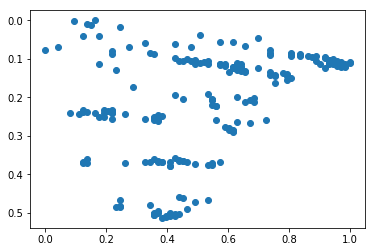

In [4]:
xs11=[215, 189, 192, 185, 189, 186, 184, 188, 160, 176, 175, 158, 159, 169, 170, 216, 208,216, 189, 191, 185, 189, 186, 184, 187, 160, 177, 174, 160, 172, 171, 217, 209,216, 189, 190, 184, 189, 187, 184, 188, 160, 174, 176, 160, 171, 171, 217, 207,214, 191, 183, 175, 185, 199, 194, 190, 158, 172, 174, 171, 176, 170, 214, 214, 205,215, 191, 179, 165, 183, 203, 193, 192, 156, 178, 175, 170, 177, 170, 215, 215, 205,214, 189, 180, 161, 177, 199, 202, 190, 157, 184, 173, 168, 174, 170, 213, 203,213, 191, 180, 160, 181, 202, 201, 195, 158, 186, 172, 170, 174, 170, 211, 213, 203,212, 191, 180, 157, 175, 202, 198, 189, 160, 184, 173, 171, 183, 174, 211, 212, 203,212, 187, 192, 177, 193, 182, 190, 197, 163, 180, 178, 153, 163, 169, 212, 205,211, 188, 199, 194, 176, 171, 175, 176, 150, 154, 162, 213, 210, 198,190, 198, 169, 170, 157, 181, 160, 153, 170, 170, 177, 152, 153, 162, 209, 198,186, 195, 168, 156, 178, 147, 151, 172, 168, 180, 154, 153, 161, 203, 192,183, 191, 164, 179, 162, 175, 144, 154, 155, 171, 171, 183, 153, 154, 162, 198, 186]
ys11=[144, 145, 148, 183, 210, 142, 177, 208, 190, 239, 293, 187, 188, 240, 292, 140, 133,144, 144, 148, 183, 208, 141, 176, 205, 189, 239, 292, 187, 240, 290, 139, 132,143, 144, 147, 182, 209, 141, 177, 206, 190, 240, 293, 188, 240, 292, 138, 132,142, 147, 141, 172, 197, 153, 179, 199, 190, 240, 295, 193, 238, 293, 137, 141, 130,143, 146, 137, 164, 171, 155, 177, 179, 190, 240, 295, 194, 239, 293, 138, 140, 131,143, 145, 140, 147, 137, 152, 157, 139, 194, 241, 296, 196, 244, 294, 138, 132,138, 144, 136, 127, 111, 153, 150, 114, 194, 240, 297, 197, 244, 294, 133, 135, 130,139, 144, 137, 140, 120, 151, 149, 118, 196, 243, 295, 198, 243, 293, 134, 136, 131,141, 143, 149, 176, 200, 138, 174, 197, 191, 242, 288, 187, 241, 284, 136, 132,145, 149, 160, 175, 137, 196, 236, 276, 190, 237, 279, 141, 140, 131,145, 152, 129, 130, 112, 139, 130, 112, 195, 237, 277, 191, 240, 285, 137, 129,140, 145, 119, 96, 135, 123, 97, 193, 240, 281, 189, 241, 286, 129, 122,137, 141, 123, 123, 103, 134, 126, 100, 101, 192, 239, 279, 189, 241, 286, 126, 118]

newX = [float(i-min(xs11)) / (max(xs11)-min(xs11)) for i in xs11]
newY = [float(j-min(ys11)) / (max(yf08)-min(ys11)) for j in ys11]

plt.plot(newX, newY,"o")
plt.gca().invert_yaxis()

In [ ]:
xs12=[159, 136, 132, 143, 158, 142, 148, 157, 112, 119, 110, 127, 136, 132, 159, 149, 158, 136, 131, 143, 157, 142, 148, 156, 111, 119, 110, 127, 135, 132, 158, 148, 158, 134, 126, 139, 154, 143, 150, 154, 110, 117, 110, 127, 135, 134, 157, 147, 156, 134, 119, 129, 142, 148, 149, 147, 108, 114, 109, 128, 134, 132, 155, 158, 143, 155, 132, 115, 111, 124, 149, 144, 136, 106, 111, 108, 127, 135, 132, 154, 157, 143, 155, 133, 354, 117, 97, 98, 148, 139, 113, 105, 109, 108, 127, 136, 133, 154, 158, 143, 158, 134, 117, 90, 91, 150, 134, 102, 105, 108, 108, 128, 139, 134, 157, 160, 144, 161, 138, 354, 123, 96, 96, 153, 135, 104, 109, 115, 109, 129, 142, 135, 160, 161, 148, 154, 131, 128, 128, 154, 134, 148, 161, 114, 129, 114, 122, 131, 135, 154, 145, 158, 135, 151, 151, 158, 119, 130, 135, 119, 108, 117, 127, 158, 151, 160, 144, 157, 128, 104, 103, 108, 130, 126, 96, 99, 131, 131, 122, 110, 115, 126, 160, 162, 149, 142, 155, 136, 124, 129, 95, 109, 132, 129, 130, 111, 113, 127, 159, 146, 142, 155, 172, 130, 179, 129, 101, 122, 133, 130, 132, 112, 114, 127, 159, 144, 142, 155, 127, 128, 100, 115, 133, 131, 133, 112, 115, 127, 159, 143]
ys12=[134, 139, 139, 177, 208, 140, 173, 205, 194, 240, 295, 195, 236, 280, 129, 122, 135, 139, 138, 177, 208, 140, 174, 206, 195, 239, 296, 196, 235, 282, 129, 122, 133, 140, 141, 176, 207, 140, 171, 205, 193, 240, 295, 193, 235, 281, 127, 121, 130, 139, 136, 172, 199, 142, 171, 199, 192, 236, 295, 195, 234, 281, 124, 128, 118, 130, 136, 131, 160, 181, 142, 163, 182, 190, 239, 295, 194, 234, 280, 124, 127, 117, 130, 135, 154, 128, 152, 138, 142, 148, 139, 191, 240, 295, 193, 233, 281, 124, 129, 117, 132, 137, 131, 141, 113, 144, 138, 109, 191, 237, 295, 194, 234, 280, 126, 129, 119, 133, 139, 154, 133, 155, 135, 145, 146, 129, 191, 237, 295, 194, 231, 279, 128, 131, 122, 135, 137, 139, 178, 198, 135, 160, 190, 189, 236, 292, 188, 235, 279, 130, 123, 135, 140, 150, 160, 148, 128, 193, 235, 284, 192, 237, 280, 132, 131, 131, 138, 145, 117, 127, 128, 97, 131, 119, 127, 101, 192, 231, 278, 189, 231, 276, 129, 128, 119, 134, 139, 122, 114, 130, 128, 105, 189, 230, 278, 186, 231, 276, 123, 115, 133, 137, 146, 113, 148, 129, 132, 113, 187, 231, 278, 185, 232, 277, 121, 113, 133, 138, 110, 128, 128, 107, 188, 230, 278, 185, 232, 277, 120, 113]

In [3]:
xs13=[206, 171, 174, 176, 180, 168, 134, 146, 142, 144, 154, 154, 208, 199, 208, 171, 173, 175, 180, 169, 136, 149, 143, 144, 155, 155, 210, 198, 206, 172, 167, 172, 188, 178, 185, 191, 134, 148, 146, 148, 156, 153, 207, 196, 208, 172, 158, 162, 190, 186, 195, 203, 133, 143, 143, 154, 161, 155, 208, 195, 209, 174, 155, 146, 167, 192, 198, 186, 132, 142, 142, 155, 167, 153, 208, 193, 192, 207, 181, 162, 132, 147, 198, 183, 164, 130, 143, 141, 153, 169, 150, 193, 208, 197, 197, 205, 197, 167, 155, 150, 184, 179, 187, 198, 137, 164, 145, 146, 151, 141, 198, 186, 198, 163, 177, 184, 189, 147, 149, 161, 148, 123, 134, 135, 200, 190, 178, 191, 174, 145, 163, 138, 144, 148, 151, 153, 122, 124, 136, 203, 185, 171, 184, 162, 153, 157, 123, 136, 147, 150, 162, 122, 147, 123, 138, 197, 177, 166, 180, 172, 162, 152, 123, 148, 148, 126, 151, 164, 123, 148, 125, 139, 190, 170, 166, 178, 159, 154, 125, 152, 149, 151, 164, 124, 125, 141, 187, 169, 161, 166, 176, 125, 150, 154, 167, 125, 148, 148, 151, 165, 124, 123, 125, 139, 166, 176]
ys13=[125, 125, 134, 178, 213, 117, 197, 262, 326, 198, 261, 324, 119, 110, 124, 127, 133, 177, 212, 120, 200, 263, 326, 199, 262, 325, 118, 110, 123, 126, 128, 172, 209, 126, 167, 202, 198, 265, 325, 198, 260, 323, 116, 107, 121, 126, 123, 164, 183, 128, 155, 182, 198, 264, 327, 200, 259, 325, 114, 106, 118, 121, 114, 142, 123, 129, 143, 124, 198, 264, 326, 202, 252, 324, 112, 105, 103, 120, 125, 117, 121, 88, 135, 125, 86, 198, 264, 324, 203, 252, 315, 99, 114, 101, 106, 110, 127, 128, 128, 170, 189, 128, 154, 183, 199, 255, 323, 197, 253, 308, 121, 110, 127, 128, 139, 155, 131, 114, 197, 252, 308, 190, 247, 303, 122, 116, 129, 135, 106, 73, 123, 101, 71, 194, 247, 302, 188, 246, 303, 118, 105, 121, 128, 85, 59, 116, 87, 53, 190, 246, 297, 186, 246, 247, 304, 106, 95, 116, 122, 93, 71, 112, 96, 65, 190, 246, 246, 297, 186, 245, 248, 304, 99, 92, 118, 121, 85, 117, 109, 82, 191, 247, 298, 187, 248, 305, 97, 91, 85, 114, 119, 119, 92, 113, 115, 118, 93, 190, 245, 298, 186, 187, 249, 305, 83, 89]


# plt.plot(xs13, ys13,"o")
# plt.gca().invert_yaxis()

# newX = [i*1.0 / (max(xs13)-min(xs13)) for i in xs13]
# newY = [j*1.0 / (max(ys13)-min(ys13)) for j in ys13]

# plt.plot(newX, newY,"o")
# plt.gca().invert_yaxis()

In [ ]:
xs14=[222, 189, 179, 183, 197, 198, 195, 196, 144, 155, 145, 163, 171, 170, 221, 205, 221, 188, 177, 183, 196, 198, 195, 196, 143, 155, 145, 162, 171, 171, 220, 203, 218, 188, 174, 178, 195, 201, 198, 196, 143, 157, 145, 164, 172, 170, 155, 217, 202, 216, 186, 166, 159, 176, 206, 198, 189, 142, 153, 147, 168, 176, 173, 215, 219, 200, 216, 187, 164, 138, 146, 209, 189, 165, 144, 152, 146, 172, 183, 172, 214, 220, 200, 217, 186, 162, 129, 128, 209, 179, 144, 142, 149, 146, 172, 187, 174, 215, 220, 201, 212, 187, 166, 127, 132, 208, 180, 141, 141, 150, 148, 169, 188, 175, 211, 215, 199, 210, 187, 164, 128, 134, 208, 183, 148, 143, 151, 147, 171, 189, 176, 151, 150, 210, 213, 197, 206, 183, 164, 165, 191, 202, 206, 209, 147, 154, 145, 168, 174, 172, 205, 209, 192, 210, 178, 186, 204, 210, 169, 197, 214, 154, 168, 147, 136, 155, 166, 211, 200, 190, 209, 193, 181, 168, 189, 153, 171, 163, 175, 158, 137, 150, 157, 216, 195, 188, 207, 175, 156, 168, 130, 138, 172, 175, 167, 144, 150, 158, 211, 190, 185, 203, 168, 147, 165, 118, 125, 177, 179, 170, 148, 154, 160, 204, 182, 183, 203, 167, 149, 150, 163, 116, 125, 182, 181, 174, 152, 158, 161, 200, 178]
ys14=[127, 128, 132, 181, 214, 126, 168, 208, 187, 258, 323, 191, 250, 303, 120, 111, 126, 128, 131, 181, 212, 127, 169, 208, 186, 258, 322, 190, 250, 302, 120, 111, 125, 127, 127, 180, 214, 128, 165, 200, 185, 256, 322, 188, 250, 303, 318, 119, 109, 123, 127, 122, 168, 208, 133, 169, 203, 186, 255, 322, 190, 247, 303, 117, 119, 107, 123, 126, 115, 148, 171, 137, 163, 177, 191, 261, 322, 196, 246, 303, 116, 119, 107, 122, 125, 112, 140, 114, 138, 141, 122, 192, 261, 323, 198, 249, 307, 115, 119, 105, 122, 123, 111, 129, 94, 138, 131, 89, 190, 261, 325, 195, 250, 306, 114, 120, 104, 122, 125, 114, 138, 106, 138, 135, 105, 191, 254, 324, 197, 247, 305, 323, 324, 115, 119, 105, 128, 128, 129, 181, 200, 130, 165, 197, 191, 256, 323, 193, 250, 301, 121, 123, 110, 134, 126, 144, 159, 153, 108, 123, 129, 188, 248, 321, 181, 245, 301, 129, 123, 121, 130, 94, 76, 112, 95, 96, 82, 190, 246, 304, 183, 249, 302, 111, 97, 111, 114, 79, 55, 110, 89, 60, 183, 244, 301, 180, 244, 299, 94, 86, 106, 108, 83, 65, 107, 100, 68, 181, 243, 304, 179, 243, 297, 85, 79, 106, 106, 93, 77, 78, 108, 113, 80, 181, 245, 305, 180, 245, 303, 83, 78]

In [9]:
xs15=[266, 230, 237, 231, 238, 223, 190, 208, 203, 174, 192, 194, 269, 260, 267, 230, 236, 230, 238, 224, 190, 208, 203, 173, 193, 194, 270, 260, 266, 227, 227, 224, 241, 225, 226, 232, 187, 205, 202, 179, 193, 196, 268, 257, 260, 229, 214, 210, 239, 244, 245, 250, 184, 195, 279, 283, 197, 205, 214, 202, 262, 255, 264, 229, 211, 199, 222, 247, 250, 239, 187, 194, 198, 211, 223, 208, 265, 255, 268, 236, 219, 191, 212, 255, 242, 230, 189, 197, 198, 213, 226, 210, 268, 263, 256, 265, 265, 235, 220, 194, 218, 251, 188, 199, 200, 211, 222, 211, 266, 255, 263, 228, 111, 225, 220, 251, 231, 245, 259, 191, 216, 203, 180, 203, 202, 216, 217, 264, 254, 230, 247, 211, 208, 217, 206, 176, 181, 191, 260, 242, 232, 245, 200, 186, 217, 181, 177, 212, 209, 214, 186, 179, 184, 256, 239, 227, 239, 199, 186, 214, 169, 172, 216, 214, 222, 191, 188, 186, 247, 230, 225, 233, 197, 187, 215, 169, 179, 217, 216, 227, 192, 189, 191, 239, 223, 223, 231, 196, 182, 216, 170, 179, 219, 219, 228, 193, 191, 192, 219, 236, 220]
ys15=[131, 129, 141, 185, 219, 119, 188, 248, 325, 179, 249, 304, 125, 115, 129, 129, 140, 184, 217, 119, 188, 248, 324, 181, 249, 304, 123, 114, 125, 126, 131, 180, 216, 120, 121, 173, 185, 252, 323, 180, 254, 312, 118, 110, 124, 128, 120, 163, 185, 137, 163, 186, 188, 251, 286, 314, 321, 194, 246, 312, 118, 108, 120, 122, 113, 141, 123, 133, 147, 128, 187, 252, 322, 195, 246, 311, 114, 105, 115, 121, 111, 120, 86, 134, 117, 86, 189, 256, 323, 196, 248, 317, 108, 104, 102, 114, 120, 123, 114, 132, 102, 134, 187, 254, 326, 194, 247, 321, 113, 105, 122, 128, 82, 131, 181, 202, 127, 167, 197, 186, 251, 325, 182, 254, 316, 326, 327, 115, 110, 128, 144, 111, 195, 252, 322, 187, 251, 303, 114, 102, 121, 130, 97, 77, 111, 104, 77, 193, 253, 312, 187, 252, 305, 104, 95, 115, 120, 93, 68, 110, 98, 65, 191, 254, 313, 189, 253, 306, 96, 90, 113, 114, 106, 81, 113, 111, 76, 191, 252, 313, 188, 250, 308, 92, 86, 113, 114, 111, 85, 113, 119, 84, 190, 252, 315, 189, 252, 309, 84, 91, 87]

# xr=[]
# yr=[]

# for i in range(len(xs15)):
#     if xs15[i] < 300:
#         xr.append(xs15[i])
#         yr.append(ys15[i])
        
# plt.plot(xr, yr,"o")
# plt.gca().invert_yaxis()

# print(xr)
# print(yr)

In [11]:
xs16=[220, 188, 182, 183, 196, 194, 196, 196, 135, 165, 142, 152, 177, 176, 173, 161, 156, 221, 210, 224, 189, 180, 181, 194, 199, 199, 195, 136, 163, 142, 159, 176, 173, 156, 223, 210, 222, 189, 171, 170, 184, 207, 202, 192, 136, 156, 143, 162, 180, 173, 222, 208, 224, 189, 166, 154, 163, 211, 197, 180, 179, 137, 153, 144, 167, 186, 176, 223, 210, 222, 187, 164, 137, 135, 161, 211, 185, 150, 136, 153, 144, 166, 189, 178, 222, 209, 223, 190, 171, 123, 126, 210, 182, 137, 138, 152, 142, 167, 189, 177, 223, 209, 224, 194, 172, 121, 131, 212, 169, 170, 173, 188, 143, 141, 155, 142, 169, 191, 176, 222, 216, 208, 213, 218, 187, 168, 160, 175, 183, 207, 205, 206, 148, 171, 145, 171, 188, 177, 217, 200, 216, 183, 197, 205, 207, 173, 158, 180, 150, 142, 173, 175, 216, 203, 192, 214, 217, 176, 167, 169, 150, 172, 170, 177, 162, 142, 164, 211, 163, 218, 200, 193, 215, 179, 156, 167, 178, 139, 145, 175, 176, 179, 143, 156, 160, 216, 197, 190, 212, 177, 244, 159, 167, 126, 140, 176, 177, 189, 144, 154, 160, 212, 191]
ys16=[110, 114, 117, 169, 208, 113, 163, 207, 179, 250, 326, 182, 238, 239, 304, 314, 319, 104, 93, 105, 113, 114, 167, 207, 113, 161, 206, 175, 248, 325, 180, 238, 301, 321, 98, 89, 104, 113, 108, 166, 207, 119, 165, 206, 174, 246, 324, 179, 235, 298, 97, 87, 104, 114, 104, 150, 185, 124, 161, 189, 190, 175, 241, 323, 183, 238, 297, 97, 90, 107, 111, 99, 137, 128, 134, 124, 134, 131, 177, 247, 324, 186, 244, 300, 100, 90, 107, 109, 100, 113, 80, 121, 111, 72, 180, 247, 327, 188, 247, 300, 100, 90, 107, 112, 102, 111, 77, 123, 100, 101, 104, 115, 73, 178, 248, 327, 186, 244, 300, 100, 97, 93, 99, 109, 117, 118, 163, 181, 185, 117, 151, 187, 183, 247, 323, 185, 239, 298, 103, 95, 108, 109, 126, 162, 158, 93, 181, 244, 317, 175, 242, 306, 103, 99, 103, 115, 101, 77, 90, 71, 101, 74, 179, 241, 306, 173, 238, 290, 303, 94, 81, 98, 104, 72, 47, 93, 72, 79, 48, 175, 239, 301, 171, 238, 303, 82, 73, 97, 101, 74, 120, 46, 93, 74, 40, 173, 238, 296, 171, 237, 303, 76, 69]

In [ ]:
xs17=[212, 188, 176, 186, 195, 201, 197, 194, 144, 156, 150, 165, 177, 173, 212, 216, 201, 211, 188, 176, 187, 196, 201, 197, 195, 144, 156, 151, 165, 177, 174, 211, 214, 201, 212, 187, 173, 180, 191, 192, 201, 196, 192, 143, 156, 151, 166, 178, 172, 212, 200, 210, 185, 167, 161, 171, 204, 192, 181, 144, 154, 150, 169, 183, 173, 210, 213, 198, 212, 186, 168, 148, 142, 205, 184, 157, 150, 154, 151, 174, 192, 175, 213, 215, 202, 211, 187, 169, 138, 129, 205, 175, 133, 150, 154, 152, 176, 195, 177, 211, 214, 202, 212, 189, 171, 142, 139, 207, 182, 144, 151, 162, 152, 175, 195, 178, 212, 214, 203, 210, 187, 173, 177, 203, 202, 207, 212, 156, 165, 150, 173, 179, 172, 210, 197, 214, 188, 175, 202, 179, 200, 173, 203, 166, 178, 161, 146, 163, 165, 217, 213, 194, 209, 176, 153, 178, 174, 145, 144, 176, 180, 176, 187, 188, 148, 155, 166, 203, 195, 194, 206, 175, 156, 181, 135, 140, 181, 183, 186, 156, 158, 169, 199, 201]
ys17=[129, 136, 136, 181, 217, 136, 173, 213, 189, 250, 314, 194, 245, 298, 123, 127, 113, 128, 134, 135, 179, 219, 135, 170, 214, 188, 249, 316, 193, 246, 299, 122, 126, 112, 126, 134, 133, 182, 218, 219, 135, 173, 214, 188, 248, 316, 192, 246, 298, 120, 110, 126, 134, 129, 175, 212, 140, 175, 209, 187, 246, 314, 190, 241, 295, 119, 123, 108, 123, 131, 123, 153, 171, 141, 161, 180, 195, 250, 316, 199, 250, 297, 118, 122, 107, 121, 125, 118, 146, 121, 134, 135, 120, 189, 248, 315, 195, 251, 297, 115, 120, 104, 124, 129, 122, 153, 126, 136, 137, 121, 191, 250, 315, 195, 248, 295, 119, 123, 109, 129, 131, 133, 183, 209, 131, 165, 202, 191, 255, 318, 190, 251, 298, 124, 115, 137, 129, 119, 145, 152, 135, 117, 140, 188, 241, 306, 183, 239, 300, 134, 130, 122, 126, 84, 60, 118, 87, 97, 67, 188, 236, 289, 314, 315, 184, 237, 292, 110, 92, 116, 117, 94, 73, 118, 111, 77, 188, 237, 295, 185, 240, 296, 92, 98]

In [15]:
xs18=[220, 227, 204, 216, 233, 252, 251, 245, 233, 220, 211, 267, 267, 284, 215, 213, 220, 225, 216, 226, 203, 216, 232, 251, 250, 245, 231, 220, 212, 265, 267, 284, 210, 216, 222, 209, 222, 199, 213, 226, 245, 244, 240, 229, 216, 212, 262, 264, 284, 205, 211, 219, 202, 218, 196, 201, 202, 240, 229, 215, 233, 216, 212, 261, 263, 284, 196, 205, 216, 194, 215, 197, 195, 173, 233, 203, 176, 226, 216, 213, 258, 260, 284, 192, 198, 214, 196, 222, 222, 195, 165, 224, 192, 161, 228, 214, 214, 255, 256, 285, 198, 211, 198, 214, 228, 193, 181, 178, 231, 211, 181, 179, 225, 212, 214, 253, 249, 285, 200, 211, 194, 195, 196, 141, 216, 236, 195, 220, 215, 236, 197, 223, 192, 202, 227, 213, 215, 254, 248, 284, 197, 149, 214, 208, 203, 219, 236, 200, 195, 200, 238, 224, 195, 194, 107, 198, 235, 217, 215, 266, 258, 285, 199, 205, 216, 224, 210, 227, 206, 215, 202, 247, 230, 203, 241, 230, 216, 276, 279, 287, 217, 222, 221, 212, 209, 220, 205, 138, 222, 208, 252, 296, 238, 267, 299, 248, 239, 208, 277, 285, 284, 200, 203, 147, 209, 225, 226, 219, 268, 244, 290, 256, 237, 272, 290, 254, 249, 205, 279, 286, 284, 217, 224, 208, 224, 238, 235, 234, 262, 257, 239, 261, 257, 259, 255, 204, 278, 286, 285, 232, 236, 220]
ys18=[98, 102, 112, 154, 197, 94, 146, 188, 166, 227, 296, 160, 225, 297, 299, 96, 90, 80, 97, 101, 110, 153, 196, 93, 143, 186, 166, 225, 295, 160, 222, 296, 95, 90, 80, 99, 102, 112, 155, 198, 95, 145, 188, 166, 229, 298, 160, 222, 297, 96, 93, 83, 99, 103, 106, 150, 196, 101, 151, 194, 170, 222, 297, 165, 223, 296, 93, 94, 86, 95, 104, 100, 142, 180, 109, 153, 181, 173, 227, 297, 169, 228, 295, 88, 91, 89, 102, 106, 94, 129, 136, 120, 137, 137, 177, 240, 301, 174, 238, 300, 97, 94, 108, 105, 91, 109, 103, 84, 97, 123, 106, 83, 181, 235, 304, 178, 243, 301, 103, 98, 105, 106, 107, 222, 107, 94, 113, 85, 65, 97, 119, 85, 91, 66, 183, 242, 304, 180, 244, 302, 100, 218, 93, 98, 110, 107, 93, 115, 93, 72, 97, 97, 111, 112, 162, 77, 185, 241, 305, 180, 245, 302, 105, 104, 97, 90, 105, 105, 114, 151, 178, 97, 149, 178, 175, 238, 301, 169, 227, 301, 89, 86, 87, 99, 96, 89, 97, 221, 96, 115, 124, 127, 77, 109, 126, 172, 229, 296, 160, 235, 300, 96, 91, 215, 80, 90, 92, 108, 74, 101, 36, 82, 77, 72, 37, 169, 234, 289, 162, 234, 301, 90, 83, 93, 74, 73, 89, 98, 58, 29, 80, 61, 28, 163, 230, 288, 161, 233, 300, 72, 68, 78]

In [19]:
xs19=[133, 156, 139, 148, 157, 174, 178, 170, 163, 152, 144, 188, 196, 208, 131, 137, 149, 134, 155, 137, 146, 156, 173, 175, 167, 161, 152, 142, 186, 196, 207, 131, 137, 149, 280, 132, 153, 136, 142, 145, 169, 170, 159, 157, 150, 143, 184, 195, 207, 130, 136, 148, 132, 233, 150, 220, 139, 135, 122, 246, 161, 151, 131, 161, 150, 143, 182, 193, 207, 130, 135, 147, 280, 129, 152, 156, 130, 107, 148, 126, 102, 160, 150, 142, 179, 190, 207, 133, 145, 285, 152, 164, 113, 117, 142, 122, 120, 109, 160, 149, 143, 177, 182, 204, 139, 284, 129, 155, 170, 142, 144, 165, 152, 144, 181, 180, 203, 132, 141, 138, 238, 165, 175, 154, 171, 158, 142, 139, 173, 155, 144, 193, 196, 207, 141, 153, 150, 175, 158, 165, 159, 191, 184, 161, 185, 171, 143, 209, 218, 217, 148, 152, 164, 157, 172, 169, 199, 223, 154, 182, 197, 238, 198, 187, 158, 215, 219, 215, 153, 157, 154, 164, 183, 197, 187, 167, 168, 184, 165, 215, 214, 199, 221, 162, 216, 210, 199, 222, 162, 216, 177, 165, 189, 199, 148, 180, 179, 162, 147, 220, 199, 160, 213, 219, 212, 183, 171, 206, 223, 208, 194, 188, 149, 173, 196, 205, 219, 173, 180, 187, 224, 206]
ys19=[115, 130, 136, 169, 197, 125, 162, 192, 188, 229, 276, 184, 230, 283, 112, 110, 106, 116, 131, 137, 169, 198, 125, 162, 193, 186, 229, 276, 183, 230, 282, 112, 110, 107, 316, 113, 129, 133, 167, 200, 125, 162, 192, 187, 230, 277, 183, 230, 282, 109, 108, 106, 112, 78, 127, 75, 126, 161, 190, 81, 129, 164, 191, 184, 229, 275, 183, 227, 281, 106, 107, 107, 314, 112, 126, 120, 147, 162, 132, 152, 165, 186, 226, 275, 185, 233, 283, 107, 107, 314, 123, 116, 124, 111, 130, 132, 105, 122, 186, 227, 273, 186, 233, 280, 108, 315, 116, 128, 119, 136, 115, 188, 228, 272, 188, 236, 283, 113, 114, 120, 74, 129, 123, 133, 128, 135, 138, 123, 189, 230, 275, 190, 237, 284, 116, 114, 123, 129, 134, 164, 184, 124, 156, 184, 187, 236, 280, 184, 232, 279, 119, 118, 113, 125, 125, 133, 130, 113, 115, 116, 115, 104, 179, 229, 274, 176, 228, 281, 123, 119, 124, 111, 118, 109, 90, 77, 126, 94, 79, 177, 178, 230, 231, 267, 283, 178, 229, 232, 262, 282, 101, 108, 112, 105, 106, 119, 120, 126, 109, 170, 229, 262, 172, 230, 282, 93, 104, 139, 142, 121, 109, 136, 122, 98, 206, 258, 309, 205, 263, 318, 123, 118]

# xr=[]
# yr=[]

# for i in range(len(xs19)):
#     if xs19[i] < 300 and xs19[i] > 70:
#         xr.append(xs19[i])
#         yr.append(ys19[i])
        
# plt.plot(xr, yr,"o")
# plt.gca().invert_yaxis()

# print(xr)
# print(yr)

In [ ]:
xs20=[238, 205, 205, 204, 215, 203, 173, 187, 179, 186, 198, 190, 189, 239, 227, 240, 206, 205, 200, 210, 207, 173, 187, 178, 187, 201, 190, 239, 227, 237, 206, 196, 188, 199, 217, 213, 207, 172, 186, 178, 193, 203, 189, 237, 225, 239, 211, 197, 175, 183, 227, 217, 202, 169, 183, 179, 192, 205, 193, 239, 343, 226, 241, 213, 196, 159, 163, 134, 169, 230, 209, 181, 167, 182, 178, 190, 206, 193, 240, 241, 227, 239, 212, 195, 159, 166, 165, 229, 214, 177, 168, 180, 177, 190, 204, 190, 241, 235, 229, 238, 212, 195, 163, 165, 230, 213, 178, 168, 179, 177, 190, 203, 191, 239, 233, 227, 240, 205, 195, 186, 207, 217, 218, 224, 174, 186, 176, 192, 193, 190, 239, 226, 234, 327, 202, 214, 217, 189, 187, 191, 177, 168, 178, 180, 186, 234, 322, 333, 225, 348, 231, 205, 222, 219, 191, 187, 224, 195, 191, 192, 200, 189, 173, 184, 187, 231, 225, 212, 182, 173, 206, 170, 225, 198, 168, 213, 182, 186, 176, 189, 188, 185, 175, 196, 204, 211, 181, 173, 180, 187, 180, 175, 225, 210, 214, 207, 223, 199, 164, 186, 193, 196, 154, 171, 191, 202, 216, 173, 180, 187, 218, 214, 206, 223, 208, 194, 188, 149, 173, 196, 205, 219, 173, 180, 187, 224, 206]
ys20=[144, 146, 152, 197, 231, 140, 208, 262, 329, 208, 260, 316, 317, 138, 131, 141, 146, 150, 193, 228, 142, 206, 260, 328, 206, 256, 313, 135, 129, 143, 148, 147, 189, 224, 150, 188, 224, 207, 261, 328, 209, 259, 315, 137, 130, 144, 150, 141, 170, 193, 159, 186, 202, 202, 262, 327, 209, 257, 311, 138, 191, 132, 145, 149, 138, 124, 167, 117, 149, 161, 169, 154, 205, 261, 329, 210, 258, 311, 139, 141, 133, 149, 148, 139, 155, 127, 128, 160, 165, 124, 208, 265, 330, 213, 260, 318, 141, 151, 136, 153, 151, 143, 163, 137, 161, 168, 133, 205, 264, 331, 210, 261, 320, 145, 155, 138, 150, 151, 151, 192, 217, 153, 186, 218, 206, 269, 332, 207, 267, 316, 144, 139, 139, 200, 143, 157, 184, 127, 205, 254, 329, 198, 243, 279, 317, 134, 194, 193, 132, 192, 130, 143, 149, 139, 110, 140, 146, 121, 109, 204, 254, 317, 202, 251, 313, 126, 126, 120, 84, 97, 142, 97, 144, 118, 120, 124, 93, 127, 96, 142, 112, 94, 129, 203, 255, 307, 125, 201, 256, 315, 83, 84, 124, 119, 115, 139, 142, 113, 124, 95, 137, 114, 119, 89, 203, 254, 306, 202, 258, 316, 114, 120, 139, 142, 121, 109, 136, 122, 98, 206, 258, 309, 205, 263, 318, 123, 118]

In [2]:
import cv2 as cv 
import numpy as np
import scipy
import PIL.Image
import math
import caffe
import time
from config_reader import config_reader
import util
import copy
import matplotlib
%matplotlib inline
import pylab as plt